# Libraries

In [1]:
import os
os.chdir('/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src')  # Provide the new path here

In [2]:
from train_test.load_train import *
from train_test.load_test import *

In [3]:
from operator import itemgetter
from tqdm import tqdm
import time
from datetime import datetime
import json
from collections import deque

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray
import rioxarray
import fiona

#import matplotlib
import matplotlib.pyplot as plt

#from rasterio.enums import Resampling

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler
from torch.utils.data.sampler import RandomSampler
import torch.nn as nn
from torch.autograd import Variable

import wandb

import torchview
from torchview import draw_graph

from utils.plot import *
import importlib

import seaborn as sns

In [4]:
from dataloaders import dataset_ST_MultiPoint
# from dataloaders import load_dataset
# from loss import losses_SparseData
# from models import models_SparseData
# from optimizer import load_optimizer

from subprocess import Popen

# Load dictionary

In [57]:
json_file = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/configs/ST_MultiPoint/ST_MultiPoint_Net_SAGW_ERA5.json" #config_files_1d/lstm_att_1.json
dict_files = {}
with open(json_file) as f:
    dict_files = json.load(f)
    print(f"Read data.json: {dict_files}")

Read data.json: {'cuda_device': 'cuda:1', 'entity': 'gsartor-unito', 'experiment_name': 'ST_MultiPoint', 'run_name': 'ST_MultiPoint_Net', 'comments': None, 'wandb_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_ST_MultiPoint/logs', 'save_model_dir': '/leonardo_scratch/fast/IscrC_DL4EO/results/results_ST_MultiPoint/models', 'dtm_nc': '/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc', 'weather_nc_path': '/leonardo_work/IscrC_DL4EO/trials/data/era5land_2000_2024_weekly.nc', 'weather_dtm': '/leonardo_work/IscrC_DL4EO/trials/data/era5land_dtm.nc', 'wtd_csv_path': '/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv', 'wtd_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp', 'piedmont_shp': '/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp', 'dataset_type': 'ST_MultiPoint', 'piezo_head': True, 'relative_target': False, 'nan_treshold': 10, 'fill_value': 0, 'normalization': True, 'target_norm_type': 'overall_z

# Dataset class

In [6]:
importlib.reload(dataset_ST_MultiPoint)

<module 'dataloaders.dataset_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/dataloaders/dataset_ST_MultiPoint.py'>

In [7]:
ds = dataset_ST_MultiPoint.Dataset_ST_MultiPoint(dict_files)

    Loading weather data... Done!
    Loading dtm... Done!
    Loading Piedmont Shapefile... Done!
    Loading underground water data... Done!
    Norm factors:
{'target_means': np.float64(297.3569370276642), 'target_stds': np.float64(73.22735588509208), 'dtm_mean': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(1139.4907, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'dtm_std': <xarray.DataArray '__xarray_dataarray_variable__' ()> Size: 4B
array(884.7991, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0, 'lat_mean': np.float64(44.800499999999964), 'lat_std': np.float64(0.3169655454549103), 'lon_mean': np.float64(7.375499999999998), 'lon_std': np.float64(0.4326943495034695), 'weather_mean': <xarray.Dataset> Size: 24B
Dimensions:      ()
Coordinates:
    spatial_ref  int64 8B 0
Data variables:
    tp           float32 4B 0.001791
    t2m          float32 4B 280.5
    pev          float32 4B -0.001864
    smlt         float32 4B 0.0005162, 'weather

In [8]:
ds[0][0][1].shape

torch.Size([4, 28, 5])

In [9]:
ds[0][0][1][:,15,3:]

tensor([[0.9327, 0.3608],
        [0.8827, 0.4700],
        [0.8200, 0.5724],
        [0.7454, 0.6666]])

In [10]:
ds[0][2].shape

torch.Size([28, 5])

In [11]:
prova = ds[0][0][2].clone()
prova

tensor([[False,  True,  True, False,  True,  True,  True, False,  True, False,
         False, False,  True,  True, False,  True, False,  True, False, False,
         False,  True,  True, False, False,  True, False,  True],
        [False,  True,  True, False,  True,  True,  True, False,  True,  True,
         False, False,  True,  True, False,  True, False,  True, False, False,
         False,  True,  True, False, False,  True, False,  True],
        [False,  True,  True, False,  True,  True,  True, False,  True,  True,
         False, False,  True,  True, False,  True, False,  True, False, False,
         False,  True,  True, False, False,  True, False,  True],
        [False,  True,  True, False,  True,  True,  True, False,  True,  True,
         False, False,  True,  True, False,  True, False,  True, False, False,
         False,  True,  True, False, False,  True, False,  True]])

In [12]:
prova *= False
prova

tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False]])

# Model 

In [80]:
from models import models_ST_MultiPoint
importlib.reload(models_ST_MultiPoint)
from models import load_model_ST_MultiPoint
importlib.reload(load_model_ST_MultiPoint)

<module 'models.load_model_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/models/load_model_ST_MultiPoint.py'>

In [76]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cpu'

In [81]:
model, _ = load_model_ST_MultiPoint.load_model(dict_files)

Model: ST_MultiPoint_Net_SAGW


In [78]:
print("Total number of trainable parameters: " ,sum(p.numel() for p in model.parameters() if p.requires_grad and p != "Densification_Dropout"))

Total number of trainable parameters:  454017


In [17]:
ds[0][0][0].shape

torch.Size([4, 28])

In [61]:
# load weights 
model_name_path = "model_ST_MultiPoint_DisNet_SAGW_K_20250902_130105" #" model_ViViT_STMoE_20250626_123108"
model_path = f"/leonardo_scratch/fast/IscrC_DL4EO/results/results_ST_MultiPoint/models/{model_name_path}.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

RuntimeError: Error(s) in loading state_dict for ST_MultiPoint_Net_SAGW:
	Missing key(s) in state_dict: "Value_Embedding_Weather.ST_layers.3.weight", "Value_Embedding_Weather.ST_layers.3.bias", "Value_Embedding_Weather.ST_layers.6.weight", "Value_Embedding_Weather.ST_layers.6.bias", "Linear.0.weight", "Linear.0.bias", "Linear.1.norm.1.weight", "Linear.1.norm.1.bias", "Joint_Module_0.norm_layer_1.norm.1.weight", "Joint_Module_0.norm_layer_1.norm.1.bias", "Joint_Module_0.mha.in_proj_weight", "Joint_Module_0.mha.in_proj_bias", "Joint_Module_0.mha.out_proj.weight", "Joint_Module_0.mha.out_proj.bias", "Joint_Module_0.norm_layer_2.norm.1.weight", "Joint_Module_0.norm_layer_2.norm.1.bias", "Joint_Module_0.mlp.0.weight", "Joint_Module_0.mlp.0.bias", "Joint_Module_0.mlp.2.weight", "Joint_Module_0.mlp.2.bias", "Joint_Module_1.norm_layer_1.norm.1.weight", "Joint_Module_1.norm_layer_1.norm.1.bias", "Joint_Module_1.mha.in_proj_weight", "Joint_Module_1.mha.in_proj_bias", "Joint_Module_1.mha.out_proj.weight", "Joint_Module_1.mha.out_proj.bias", "Joint_Module_1.norm_layer_2.norm.1.weight", "Joint_Module_1.norm_layer_2.norm.1.bias", "Joint_Module_1.mlp.0.weight", "Joint_Module_1.mlp.0.bias", "Joint_Module_1.mlp.2.weight", "Joint_Module_1.mlp.2.bias", "Joint_Module_2.norm_layer_1.norm.1.weight", "Joint_Module_2.norm_layer_1.norm.1.bias", "Joint_Module_2.mha.in_proj_weight", "Joint_Module_2.mha.in_proj_bias", "Joint_Module_2.mha.out_proj.weight", "Joint_Module_2.mha.out_proj.bias", "Joint_Module_2.norm_layer_2.norm.1.weight", "Joint_Module_2.norm_layer_2.norm.1.bias", "Joint_Module_2.mlp.0.weight", "Joint_Module_2.mlp.0.bias", "Joint_Module_2.mlp.2.weight", "Joint_Module_2.mlp.2.bias", "Joint_Module_3.norm_layer_1.norm.1.weight", "Joint_Module_3.norm_layer_1.norm.1.bias", "Joint_Module_3.mha.in_proj_weight", "Joint_Module_3.mha.in_proj_bias", "Joint_Module_3.mha.out_proj.weight", "Joint_Module_3.mha.out_proj.bias", "Joint_Module_3.norm_layer_2.norm.1.weight", "Joint_Module_3.norm_layer_2.norm.1.bias", "Joint_Module_3.mlp.0.weight", "Joint_Module_3.mlp.0.bias", "Joint_Module_3.mlp.2.weight", "Joint_Module_3.mlp.2.bias", "Output.0.weight", "Output.0.bias", "Output.2.weight", "Output.2.bias". 
	Unexpected key(s) in state_dict: "HydrConductivity.ST_layers.0.weight", "HydrConductivity.ST_layers.0.bias", "HydrConductivity.ST_layers.3.weight", "HydrConductivity.ST_layers.3.bias", "HydrConductivity.ST_layers.6.weight", "HydrConductivity.ST_layers.6.bias", "HydrConductivity_Linear.0.weight", "HydrConductivity_Linear.0.bias", "Linear_CD_GW.0.weight", "Linear_CD_GW.0.bias", "Linear_CD_S.0.weight", "Linear_CD_S.0.bias", "Linear_1_GW.0.weight", "Linear_1_GW.0.bias", "Displacement_Module_GW_0.mha.in_proj_weight", "Displacement_Module_GW_0.mha.in_proj_bias", "Displacement_Module_GW_0.mha.out_proj.weight", "Displacement_Module_GW_0.mha.out_proj.bias", "Displacement_Module_GW_0.mlp.0.weight", "Displacement_Module_GW_0.mlp.0.bias", "Displacement_Module_GW_0.mlp.2.weight", "Displacement_Module_GW_0.mlp.2.bias", "Displacement_Module_GW_1.mha.in_proj_weight", "Displacement_Module_GW_1.mha.in_proj_bias", "Displacement_Module_GW_1.mha.out_proj.weight", "Displacement_Module_GW_1.mha.out_proj.bias", "Displacement_Module_GW_1.mlp.0.weight", "Displacement_Module_GW_1.mlp.0.bias", "Displacement_Module_GW_1.mlp.2.weight", "Displacement_Module_GW_1.mlp.2.bias", "Linear_Lag.0.weight", "Linear_Lag.0.bias", "Linear_Lag.3.weight", "Linear_Lag.3.bias", "Linear_2_GW.0.weight", "Linear_2_GW.0.bias", "Linear_2_GW.3.weight", "Linear_2_GW.3.bias", "Linear_2_S.0.weight", "Linear_2_S.0.bias", "Linear_2_S.3.weight", "Linear_2_S.3.bias", "Value_Embedding_Weather.ST_layers.2.weight", "Value_Embedding_Weather.ST_layers.2.bias", "Value_Embedding_Weather.ST_layers.4.weight", "Value_Embedding_Weather.ST_layers.4.bias". 
	size mismatch for Value_Embedding_GW.ST_layers.0.weight: copying a param with shape torch.Size([32, 7]) from checkpoint, the shape in current model is torch.Size([64, 7]).
	size mismatch for Value_Embedding_GW.ST_layers.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for Value_Embedding_GW.ST_layers.2.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for Value_Embedding_GW.ST_layers.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for Value_Embedding_GW.ST_layers.4.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for Value_Embedding_GW.ST_layers.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for Value_Embedding_Weather.ST_layers.0.weight: copying a param with shape torch.Size([32, 9, 1, 5, 5]) from checkpoint, the shape in current model is torch.Size([64, 9, 1, 5, 5]).
	size mismatch for Value_Embedding_Weather.ST_layers.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for S_coords_Embedding.ST_layers.0.weight: copying a param with shape torch.Size([32, 3]) from checkpoint, the shape in current model is torch.Size([64, 2]).
	size mismatch for S_coords_Embedding.ST_layers.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for S_coords_Embedding.ST_layers.2.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for S_coords_Embedding.ST_layers.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for S_coords_Embedding.ST_layers.4.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for S_coords_Embedding.ST_layers.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for SAGW_Module.multihead_att.in_proj_weight: copying a param with shape torch.Size([96, 32]) from checkpoint, the shape in current model is torch.Size([192, 64]).
	size mismatch for SAGW_Module.multihead_att.in_proj_bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for SAGW_Module.multihead_att.out_proj.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for SAGW_Module.multihead_att.out_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for SAGW_Module.norm_linear.2.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for SAGW_Module.norm_linear.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for SAGW_Module.norm_linear.4.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for SAGW_Module.norm_linear.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for GW_lags_Module.multihead_att.in_proj_weight: copying a param with shape torch.Size([96, 32]) from checkpoint, the shape in current model is torch.Size([192, 64]).
	size mismatch for GW_lags_Module.multihead_att.in_proj_bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for GW_lags_Module.multihead_att.out_proj.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for GW_lags_Module.multihead_att.out_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for GW_lags_Module.norm_linear.2.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for GW_lags_Module.norm_linear.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for GW_lags_Module.norm_linear.4.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for GW_lags_Module.norm_linear.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for Weather_lags_Module.multihead_att.in_proj_weight: copying a param with shape torch.Size([96, 32]) from checkpoint, the shape in current model is torch.Size([192, 64]).
	size mismatch for Weather_lags_Module.multihead_att.in_proj_bias: copying a param with shape torch.Size([96]) from checkpoint, the shape in current model is torch.Size([192]).
	size mismatch for Weather_lags_Module.multihead_att.out_proj.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for Weather_lags_Module.multihead_att.out_proj.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for Weather_lags_Module.norm_linear.2.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for Weather_lags_Module.norm_linear.2.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for Weather_lags_Module.norm_linear.4.weight: copying a param with shape torch.Size([32, 32]) from checkpoint, the shape in current model is torch.Size([64, 64]).
	size mismatch for Weather_lags_Module.norm_linear.4.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).

In [41]:
i = 0
X = ds[i][0]
perturbed_X_0 = torch.where(X[2].unsqueeze(0),1,X[0].unsqueeze(0))
X = [perturbed_X_0,
     X[1].unsqueeze(0),
     X[2].unsqueeze(0)]
W = ds[i][1]
W = [W[0].unsqueeze(0),
     W[1].unsqueeze(0)]
Z = ds[i][2].unsqueeze(0)

In [147]:
W[1][:,3:,:,10,7]

tensor([[[0.7454, 0.8200, 0.8827, 0.9327, 0.9692],
         [0.6666, 0.5724, 0.4700, 0.3608, 0.2464]]])

In [143]:
W[1].shape

torch.Size([1, 5, 5, 12, 16])

In [83]:
model.train()
prova_out = model(X, W, Z)

torch.Size([1, 28, 66, 4])
torch.Size([1, 28, 66, 5])


In [ ]:
model.train()
prova_out, Displacement_GW, Displacement_S, Permeability, Lag_GW = model(X, W, Z, get_displacement_terms = True, get_lag_term = True)

In [123]:
cache_1 = model.cache_GW_out
cache_1

tensor([[[[-0.2774, -0.2767, -0.2875, -0.2929],
          [ 0.1692,  0.1810,  0.1936,  0.2061],
          [ 0.1529,  0.1417,  0.1354,  0.1216],
          ...,
          [-0.2300, -0.2489, -0.2653, -0.2763],
          [ 0.1206,  0.1377,  0.1575,  0.1710],
          [-0.1102, -0.1040, -0.0946, -0.0857]],

         [[-0.2774, -0.2767, -0.2875, -0.2929],
          [ 0.1692,  0.1810,  0.1936,  0.2061],
          [ 0.1529,  0.1417,  0.1354,  0.1216],
          ...,
          [-0.2300, -0.2489, -0.2653, -0.2763],
          [ 0.1206,  0.1377,  0.1575,  0.1710],
          [-0.1102, -0.1040, -0.0946, -0.0857]],

         [[-0.2774, -0.2767, -0.2875, -0.2929],
          [ 0.1692,  0.1810,  0.1936,  0.2061],
          [ 0.1529,  0.1416,  0.1354,  0.1216],
          ...,
          [-0.2300, -0.2489, -0.2653, -0.2763],
          [ 0.1206,  0.1377,  0.1575,  0.1710],
          [-0.1102, -0.1041, -0.0946, -0.0857]],

         ...,

         [[-0.2774, -0.2767, -0.2875, -0.2929],
          [ 0.1692,  0

In [120]:
cache_0 = model.cache_GW_out
cache_0

tensor([[[[-0.2774, -0.2767, -0.2875, -0.2929],
          [ 0.1692,  0.1810,  0.1936,  0.2061],
          [ 0.1529,  0.1417,  0.1354,  0.1216],
          ...,
          [-0.2300, -0.2489, -0.2653, -0.2763],
          [ 0.1206,  0.1377,  0.1575,  0.1710],
          [-0.1102, -0.1040, -0.0946, -0.0857]],

         [[-0.2774, -0.2767, -0.2875, -0.2929],
          [ 0.1692,  0.1810,  0.1936,  0.2061],
          [ 0.1529,  0.1417,  0.1354,  0.1216],
          ...,
          [-0.2300, -0.2489, -0.2653, -0.2763],
          [ 0.1206,  0.1377,  0.1575,  0.1710],
          [-0.1102, -0.1040, -0.0946, -0.0857]],

         [[-0.2774, -0.2767, -0.2875, -0.2929],
          [ 0.1692,  0.1810,  0.1936,  0.2061],
          [ 0.1529,  0.1416,  0.1354,  0.1216],
          ...,
          [-0.2300, -0.2489, -0.2653, -0.2763],
          [ 0.1206,  0.1377,  0.1575,  0.1710],
          [-0.1102, -0.1041, -0.0946, -0.0857]],

         ...,

         [[-0.2774, -0.2767, -0.2875, -0.2929],
          [ 0.1692,  0

In [124]:
(cache_1 == cache_0).all()

tensor(True)

<Axes: xlabel='date,sensor_id'>

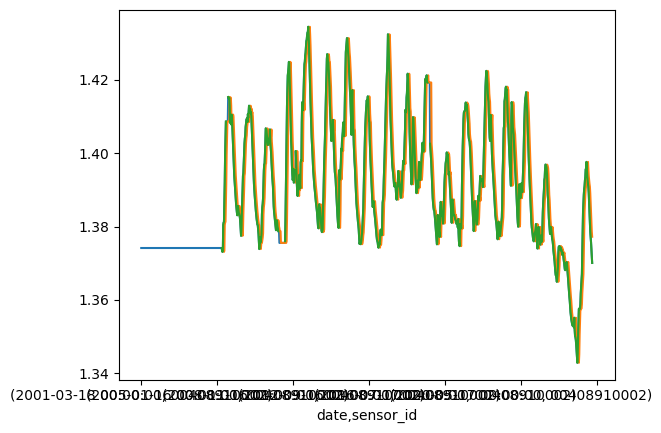

In [71]:
ds.lagged_df.groupby(level="sensor_id").ffill().groupby(level="sensor_id").bfill() .loc[pd.IndexSlice[:,"00408910002"],"h"].plot()
ds.lagged_df.groupby(level="sensor_id").ffill().loc[pd.IndexSlice[:,"00408910002"],"00408910002_lag4"].plot()
ds.lagged_df.loc[pd.IndexSlice[:,"00408910002"],"h"].plot()

In [75]:
ds.lagged_df.groupby(level="sensor_id").ffill().groupby(level="sensor_id").bfill()

h       lat       lon    height   doy_sin  \
date       sensor_id                                                       
2001-03-18 00103510001  0.707146  0.092573 -0.154837 -0.866947  0.969178   
           00104110001 -0.339796  0.244253  0.092673 -0.951262  0.969178   
           00105110001 -0.893803  0.492360  0.515847 -1.021212  0.969178   
           00105910001 -0.891028  0.190429  0.804935 -1.018794  0.969178   
           00105910002 -0.998012  0.275844  0.719558 -1.028230  0.969178   
...                          ...       ...       ...       ...       ...   
2023-12-24 00417910001 -0.618669 -0.087850  0.722069 -0.997253 -0.136906   
           00421510001  0.210403 -0.487574  0.639993 -0.929923 -0.136906   
           00421710001 -0.213318 -0.349954  0.444199 -0.962027 -0.136906   
           00422510001  1.752633 -0.890702  0.362317 -0.777247 -0.136906   
           00425010001  1.129011 -0.726844  0.461141 -0.852743 -0.136906   

                         doy_cos  doy_sin_lag1  doy_cos_lag1  \
date       sensor_id                                           
2001-03-18 00103510001  0.246361      0.932655      0.360771   
           00104110001  0.246361      0.932655      0.360771   
           00105110001  0.246361      0.932655      0.360771   
           00105910001  0.246361      0.932655      0.360771   
           00105910002  0.246361      0.932655      0.360771   
...                          ...           ...           ...   
2023-12-24 00417910001  0.990584     -0.254671      0.967028   
           00421510001  0.990584     -0.254671      0.967028   
           00421710001  0.990584     -0.254671      0.967028   
           00422510001  0.990584     -0.254671      0.967028   
           00425010001  0.990584     -0.254671      0.967028   

                        00103510001_lag1  00104110001_lag1  ...  \
date       sensor_id                                        ...   
2001-03-18 00103510001          0.705854         -0.339796  ...   
           00104110001          0.705854         -0.339796  ...   
           00105110001          0.705854         -0.339796  ...   
           00105910001          0.705854         -0.339796  ...   
           00105910002          0.705854         -0.339796  ...   
...                                  ...               ...  ...   
2023-12-24 00417910001          0.677322         -0.330531  ...   
           00421510001          0.677322         -0.330531  ...   
           00421710001          0.677322         -0.330531  ...   
           00422510001          0.677322         -0.330531  ...   
           00425010001          0.677322         -0.330531  ...   

                        00407810001_lag4  00408910001_lag4  00408910002_lag4  \
date       sensor_id                                                           
2001-03-18 00103510001          2.450884          0.738736          1.374162   
           00104110001          2.450884          0.738736          1.374162   
           00105110001          2.450884          0.738736          1.374162   
           00105910001          2.450884          0.738736          1.374162   
           00105910002          2.450884          0.738736          1.374162   
...                                  ...               ...               ...   
2023-12-24 00417910001          2.432982          0.716559          1.377237   
           00421510001          2.432982          0.716559          1.377237   
           00421710001          2.432982          0.716559          1.377237   
           00422510001          2.432982          0.716559          1.377237   
           00425010001          2.432982          0.716559          1.377237   

                        00414310002_lag4  00417910001_lag4  00421510001_lag4  \
date       sensor_id                                                           
2001-03-18 00103510001         -0.652378         -0.609543          0.213877   
           00104110001         -0.652378         -0.6095

In [41]:
ds.dates[ds.dates>np.datetime64("2016-01-02")]

DatetimeIndex(['2016-01-03', '2016-01-10', '2016-01-17', '2016-01-24',
               '2016-01-31', '2016-02-07', '2016-02-14', '2016-02-21',
               '2016-02-28', '2016-03-06',
               ...
               '2023-10-22', '2023-10-29', '2023-11-05', '2023-11-12',
               '2023-11-19', '2023-11-26', '2023-12-03', '2023-12-10',
               '2023-12-17', '2023-12-24'],
              dtype='datetime64[ns]', name='date', length=417, freq=None)

In [156]:
a = [nn.Linear(1,1)]
a.append(nn.Linear(1,1))
nn.Sequential(*a)

Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
  (1): Linear(in_features=1, out_features=1, bias=True)
)

In [153]:
batch, sentence_length, embedding_dim = 20, 5, 10
embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(embedding_dim, elementwise_affine=False)
# Activate module
torch_layernorm = layer_norm(embedding)
instancenorm = nn.InstanceNorm1d(embedding_dim, affine=False, device = device)
torch_instancenorm = instancenorm(embedding.permute(0,2,1))

In [152]:
torch_instancenorm[0,:,1].mean()

tensor(0.2769)

In [147]:
torch_instancenorm.permute(0,2,1) == torch_layernorm

tensor([[[False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False]],

        [[False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False]],

        [[False, False, False, False, False, False, False, False, False, False],
         [False, False, False, False, False, False, False, False, False, False],
         [False, False, 

In [126]:
layer_norm.weight.shape

torch.Size([10])

## Grid prediction

In [48]:
from utils import plot_ST_MultiPoint
importlib.reload(plot_ST_MultiPoint)

<module 'utils.plot_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot_ST_MultiPoint.py'>

In [49]:
lat_points = 42
lon_points = 62
z_grid = plot_ST_MultiPoint.grid_generation(ds, lat_points,lon_points)

In [84]:
from models import models_ST_MultiPoint
importlib.reload(models_ST_MultiPoint)
from models import load_model_ST_MultiPoint
importlib.reload(load_model_ST_MultiPoint)
model, _ = load_model_ST_MultiPoint.load_model(dict_files)

Model: ST_MultiPoint_Net_SAGW


In [85]:
model.train()
_ , Y_hat_test, Z_pred = plot_ST_MultiPoint.compute_predictions_MultiPoint(np.datetime64("2018-01-07"),
                                         ds,
                                         model,
                                         device,
                                         Z_grid = z_grid,
                                         get_Z = True)

In [207]:
ds[0][2].shape

torch.Size([28, 5])

In [182]:
Y_hat_test.shape

torch.Size([2604])

In [83]:
ds[0][0][0].shape

torch.Size([4, 28])

In [86]:
coords = Z_pred.reshape(lat_points,lon_points,5)
Y_hat_test_grid = Y_hat_test.reshape(lat_points,lon_points)

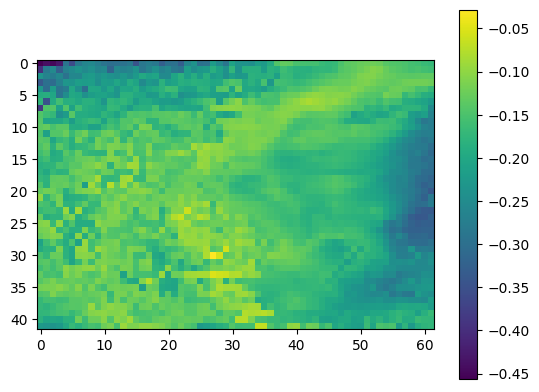

In [87]:
plt.imshow(Y_hat_test_grid.detach().cpu())
plt.colorbar()

In [27]:
sensor_idx = 8
sensor = ds.sensor_id_list[sensor_idx]
munic = ds.wtd_geodf.loc[ds.wtd_geodf["sensor_id"] == sensor,"munic"].values[0]
sensor_coords = ds.wtd_geodf.loc[ds.wtd_geodf["sensor_id"] == sensor,"geometry"]
sensor_x = sensor_coords.x.values[0]
print(sensor_x)
sensor_y = sensor_coords.y.values[0]
print(sensor_y)

7.534462842811861
45.01630171626975


In [28]:
ds[0][1][1]

tensor([[[[ 1.5933,  1.5933,  1.5933,  ...,  1.5933,  1.5933,  1.5933],
          [ 1.3036,  1.3036,  1.3036,  ...,  1.3036,  1.3036,  1.3036],
          [ 1.0139,  1.0139,  1.0139,  ...,  1.0139,  1.0139,  1.0139],
          ...,
          [-1.0139, -1.0139, -1.0139,  ..., -1.0139, -1.0139, -1.0139],
          [-1.3036, -1.3036, -1.3036,  ..., -1.3036, -1.3036, -1.3036],
          [-1.5933, -1.5933, -1.5933,  ..., -1.5933, -1.5933, -1.5933]],

         [[ 1.5933,  1.5933,  1.5933,  ...,  1.5933,  1.5933,  1.5933],
          [ 1.3036,  1.3036,  1.3036,  ...,  1.3036,  1.3036,  1.3036],
          [ 1.0139,  1.0139,  1.0139,  ...,  1.0139,  1.0139,  1.0139],
          ...,
          [-1.0139, -1.0139, -1.0139,  ..., -1.0139, -1.0139, -1.0139],
          [-1.3036, -1.3036, -1.3036,  ..., -1.3036, -1.3036, -1.3036],
          [-1.5933, -1.5933, -1.5933,  ..., -1.5933, -1.5933, -1.5933]],

         [[ 1.5933,  1.5933,  1.5933,  ...,  1.5933,  1.5933,  1.5933],
          [ 1.3036,  1.3036,  

## FDif trials

In [ ]:
K = torch.ones_like(Y_hat_test_grid)
Lag_GW_t = Y_hat_test_grid[None,None,:,:]
        
dh_dy = Fdiff_conv(Lag_GW_t, mode = "first_lat")
dh_dx = Fdiff_conv(Lag_GW_t, mode = "first_lon")

dh_dy = dh_dy * K[None,None,:,:]
dh_dx = dh_dx * K[None,None,:,:]

dh_dydy = Fdiff_conv(dh_dy, mode = "first_lat")
dh_dxdx = Fdiff_conv(dh_dx, mode = "first_lon")

spatial_grad = dh_dydy + dh_dxdx

## ST Grid

In [29]:
from models import load_model_ST_MultiPoint
importlib.reload(load_model_ST_MultiPoint)

<module 'models.load_model_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/models/load_model_ST_MultiPoint.py'>

In [41]:
date = np.datetime64("2006-01-01")
n_pred = 12
true, predictions = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, date, n_pred)

  0%|          | 0/12 [00:00<?, ?it/s]

 83%|████████▎ | 10/12 [00:12<00:02,  1.41s/it]

: 

In [21]:
predictions.shape

torch.Size([12, 28])

In [105]:
predictions.requires_grad

True

In [22]:
_, predictions_grid = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, date, n_pred,
                                                    iter_pred = False,
                                                    Z_grid = z_grid)

100%|██████████| 12/12 [00:18<00:00,  1.52s/it]


In [23]:
coords = z_grid.reshape(lat_points,lon_points,3)

In [24]:
predictions_grid = predictions_grid.reshape(n_pred,lat_points,lon_points)

In [22]:
start_date_idx = ds.dates.get_loc(np.datetime64(date))
date_seq = [ds.dates[start_date_idx+i] for i in range(n_pred)]
predictions_grid_xr = xarray.DataArray(data = predictions_grid,
                                coords = dict(
                                            lat=("lat", coords[:,0,0]),
                                            lon=("lon", coords[0,:,1]),
                                            time=date_seq),
                                dims = ["time","lat", "lon"]
                                )

In [ ]:
predictions_grid_xr.sel()

## Displacement

In [24]:
from models import models_ST_MultiPoint
importlib.reload(models_ST_MultiPoint)
from models import load_model_ST_MultiPoint
importlib.reload(load_model_ST_MultiPoint)
# dict_files["model_init"] = None
# model, _ = load_model_ST_MultiPoint.load_model(dict_files)

<module 'models.load_model_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/models/load_model_ST_MultiPoint.py'>

In [31]:
_ , Y_hat_test, Displacement_GW, Displacement_S, Permeability, Lag_GW, Z_pred = plot_ST_MultiPoint.compute_predictions_MultiPoint(np.datetime64("2022-02-06"),
                                         ds,
                                         model,
                                         device,
                                         Z_grid = z_grid,
                                         get_Z = True,
                                         get_displacement_terms = True)

In [33]:
Y_hat_test_grid = Y_hat_test.reshape(lat_points,lon_points)
Displacement_GW_grid = Displacement_GW.reshape(lat_points,lon_points)
Displacement_S = Displacement_S.reshape(lat_points,lon_points)
Lag_GW = Lag_GW.reshape(lat_points,lon_points)
Permeability = Permeability.reshape(lat_points,lon_points)

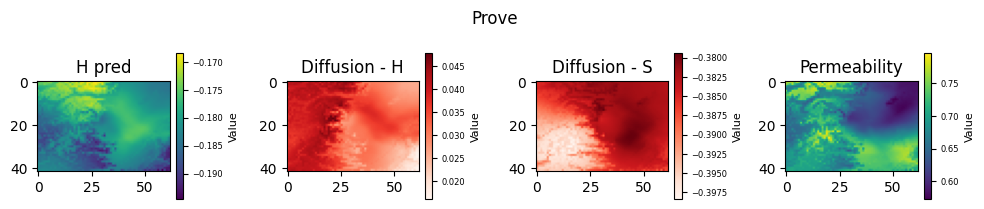

In [35]:
from matplotlib.colors import TwoSlopeNorm
norm = TwoSlopeNorm(vcenter=0)

fig, ax = plt.subplots(1,4, figsize = (10,5))

plt.suptitle("Prove", y = 0.7)

im1 = ax[0].imshow(Y_hat_test_grid.detach().cpu())
ax[0].set_title("H pred")
cbar = plt.colorbar(im1, ax = ax[0], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

im2 = ax[1].imshow(Displacement_GW_grid.detach().cpu(), cmap = "Reds",# norm = norm
                   )
ax[1].set_title("Diffusion - H")
cbar = plt.colorbar(im2, ax = ax[1], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

im3 = ax[2].imshow(Displacement_S.detach().cpu(), cmap = "Reds",# norm = norm
                   )
ax[2].set_title("Diffusion - S")
cbar =plt.colorbar(im3, ax = ax[2], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

im4 = ax[3].imshow(Permeability.detach().cpu())
ax[3].set_title("Permeability")
cbar = plt.colorbar(im4, ax = ax[3], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

plt.tight_layout()

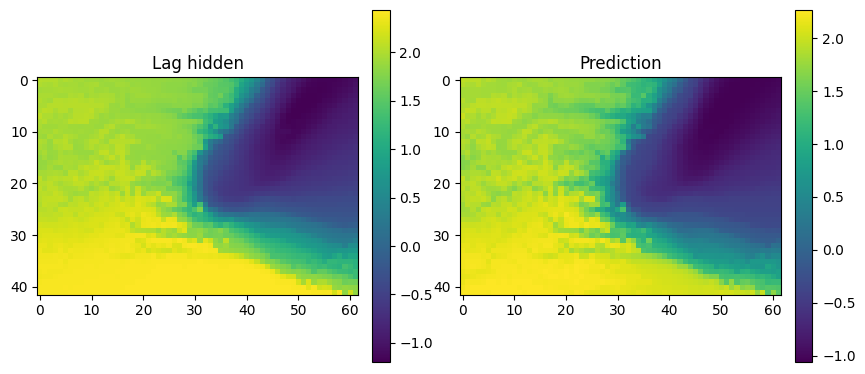

In [33]:
fig, ax = plt.subplots(1,2, figsize = (10,5))

im0 = ax[0].imshow(Lag_GW[-1],# vmin = Y_hat_test_grid.min(), vmax = Y_hat_test_grid.max()
                   )
ax[0].set_title("Lag hidden")
cbar = plt.colorbar(im0, ax = ax[0], fraction=0.05, pad=0.04)

im1 = ax[1].imshow(Y_hat_test_grid, vmin = Y_hat_test_grid.min(), vmax = Y_hat_test_grid.max())
ax[1].set_title("Prediction")
cbar = plt.colorbar(im1, ax = ax[1], fraction=0.05, pad=0.04)


In [26]:
importlib.reload(plot_ST_MultiPoint)

<module 'utils.plot_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot_ST_MultiPoint.py'>

In [15]:
lat_points = 30
lon_points = 30
Z_grid = plot_ST_MultiPoint.grid_generation(ds, lat_points,lon_points)

In [16]:
date = np.datetime64("2021-07-04")
n_pred = 3
true, predictions, Displacement_GW, Displacement_S, Permeability, Lag_GW = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, date, n_pred,
                                                                        get_displacement_terms = True,
                                                                        Z_grid = Z_grid)

100%|██████████| 3/3 [00:01<00:00,  1.53it/s]


In [17]:
predictions_grid = predictions.reshape(n_pred,lat_points,lon_points)
Displacement_GW_grid = Displacement_GW.reshape(n_pred,lat_points,lon_points)
Displacement_S_grid = Displacement_S.reshape(n_pred,lat_points,lon_points)
Permeability_grid = Permeability.reshape(n_pred,lat_points,lon_points)
Lag_GW_grid = Lag_GW.reshape(n_pred,lat_points,lon_points)

### Test loss gradient

In [73]:
from loss.losses_ST_MultiPoint import *

In [74]:
Lag_GW.shape

torch.Size([4, 4, 2604])

In [25]:
diff_loss = diffusion_loss(
                        Lag_GW = Lag_GW[:,0,:].reshape(4,
                                                42,
                                                62),
                        Displacement_GW = Displacement_GW.reshape(4,
                                                42,
                                                62),
                        K = Permeability.reshape(4,
                                                42,
                                                62),
                        res_fn = "mse",
                        normf_mu = ds.norm_factors["target_means"],
                        normf_sigma = ds.norm_factors["target_stds"],
                        )

In [37]:
reg_diffusion_loss = displacement_reg(Displacement_GW/(Permeability+1e-7),
                                                                        res_fn = "mse")

In [20]:
reg_displacement_S_loss = displacement_reg(Displacement_S,
                res_fn = "mse")

In [23]:
reg_displacement_S_loss

tensor(0.0002, grad_fn=<MeanBackward0>)

In [22]:
loss = reg_displacement_S_loss

model.train(True)
for p in model.parameters():
    if p.grad is not None:
        p.grad.zero_()

# check graph connectivity via autograd.grad (None => disconnected)
params = [(n, p) for n, p in model.named_parameters() if p.requires_grad]
grads = torch.autograd.grad(loss, [p for _, p in params], retain_graph=True, allow_unused=True)

for (name, p), g in zip(params, grads):
    if g is None:
        print(f"{name:40s} connected=False grad_norm=None")
    else:
        print(f"{name:40s} connected=True  grad_norm={g.norm().item():.6g}")

# also populate .grad fields and inspect
for p in model.parameters():
    if p.grad is not None:
        p.grad.zero_()
        
loss.backward()

for name, p in params:
    g = p.grad
    if g is None:
        print(f"[.grad] {name:34s} has_grad=False grad_norm=None")
    else:
        print(f"[.grad] {name:34s} has_grad=True  grad_norm={g.norm().item():.6g}")

Value_Embedding_GW.ST_layers.0.weight    connected=False grad_norm=None
Value_Embedding_GW.ST_layers.0.bias      connected=False grad_norm=None
Value_Embedding_GW.ST_layers.2.weight    connected=False grad_norm=None
Value_Embedding_GW.ST_layers.2.bias      connected=False grad_norm=None
Value_Embedding_GW.ST_layers.3.weight    connected=False grad_norm=None
Value_Embedding_GW.ST_layers.3.bias      connected=False grad_norm=None
Value_Embedding_GW.ST_layers.5.weight    connected=False grad_norm=None
Value_Embedding_GW.ST_layers.5.bias      connected=False grad_norm=None
Value_Embedding_GW.ST_layers.6.weight    connected=False grad_norm=None
Value_Embedding_GW.ST_layers.6.bias      connected=False grad_norm=None
Value_Embedding_Weather.ST_layers.0.weight connected=True  grad_norm=0.00426697
Value_Embedding_Weather.ST_layers.0.bias connected=True  grad_norm=0.00216625
Value_Embedding_Weather.ST_layers.2.weight connected=True  grad_norm=0.000816234
Value_Embedding_Weather.ST_layers.2.bias 

### Physics Loss

In [79]:
Lag_GW_denorm = (Lag_GW[:,0,:].reshape(4,42,62)*ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]
K_denorm = Permeability.reshape(4,42,62)*ds.norm_factors["target_stds"]
Displacement_GW_denorm = Displacement_GW.reshape(4,42,62)*ds.norm_factors["target_stds"]
dx = 1
dy = 1

spatial_grads = groundwater_flow_equation(Lag_GW_denorm,
                            K_denorm,
                            dx,
                            dy)
    
spatial_grads = spatial_grads/ds.norm_factors["target_stds"]

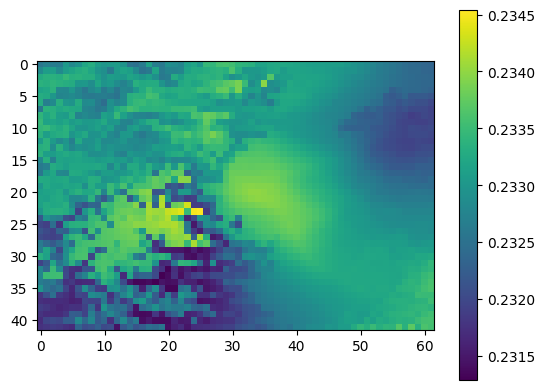

In [77]:
plt.imshow(Lag_GW[-1,0,:].reshape(42,62).detach().cpu())
plt.colorbar()

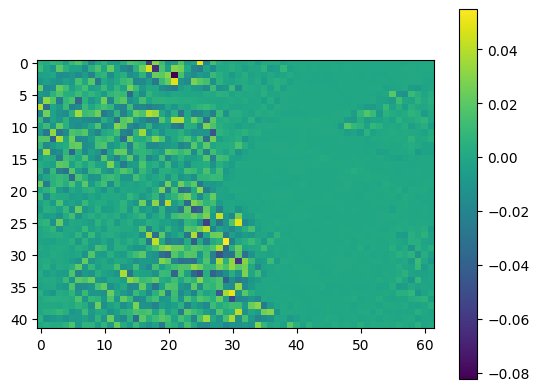

In [80]:
plt.imshow(spatial_grads[0].detach().cpu())
plt.colorbar()

In [81]:
# define new grid
new_lat = np.linspace(ds.dtm_roi.y.min().values, ds.dtm_roi.y.max().values, 42)
new_lon = np.linspace(ds.dtm_roi.x.min().values, ds.dtm_roi.x.max().values, 62)

ds_new = ds.dtm_roi.interp(y=new_lat, x=new_lon)

dtm_sample = ds_new[0].values

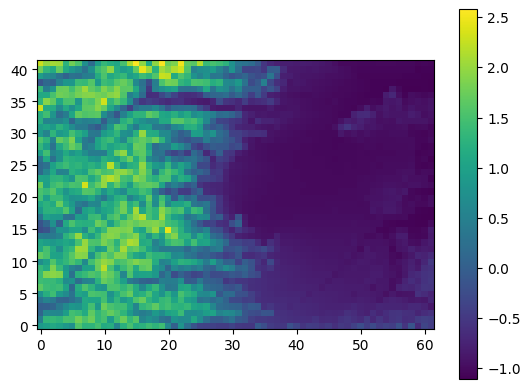

In [84]:
plt.imshow(dtm_sample, origin="lower")
plt.colorbar()

In [82]:
image = torch.tensor(dtm_sample[None,None,:,:]).to(torch.float32)
        
lon_2derivative = Fdiff_conv(image,
                mode = "centered_lon",
                der_order = 2)
lon_2derivative = lon_2derivative / (dx**2)

lat_2derivative = Fdiff_conv(image,
                mode = "centered_lat",
                der_order = 2)
lat_2derivative = lat_2derivative / (dy**2)
        
spatial_grad = (lon_2derivative + lat_2derivative)

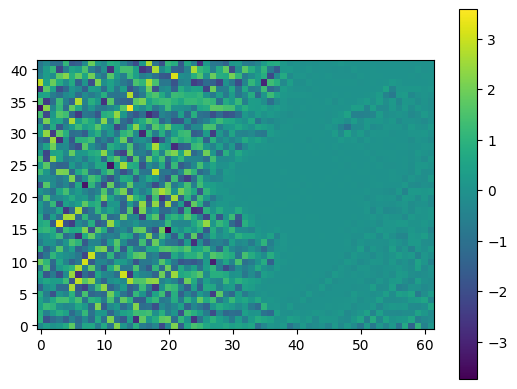

In [83]:
plt.imshow(spatial_grad.detach().cpu().squeeze(), origin="lower")
plt.colorbar()

### Plots

np.float64(44.8125)

In [19]:
start_date_idx = ds.dates.get_loc(np.datetime64(date))
date_seq = [ds.dates[start_date_idx+i] for i in range(n_pred)]

Z_grid_matrix = Z_grid.reshape(lat_points,lon_points,3)
Z_grid_matrix_lat = (Z_grid_matrix[:,:,0] * ds.norm_factors["lat_std"] ) + ds.norm_factors["lat_mean"]
Z_grid_matrix_lon = (Z_grid_matrix[:,:,1] * ds.norm_factors["lon_std"] ) + ds.norm_factors["lon_mean"]
dtm = Z_grid_matrix[:,:,2]
                
predictions_xr = xarray.DataArray(data = predictions_grid.detach().cpu(),
                                coords = dict(
                                            lat=("lat", Z_grid_matrix_lat[:,0]),
                                            lon=("lon", Z_grid_matrix_lon[0,:]),
                                            time=date_seq),
                                dims = ["time","lat", "lon"]
                                )
            
displacement_gw_xr = xarray.DataArray(data = Displacement_GW_grid.detach().cpu(),
                    coords = dict(
                                lat=("lat", Z_grid_matrix_lat[:,0]),
                                lon=("lon", Z_grid_matrix_lon[0,:]),
                                time=date_seq),
                    dims = ["time","lat", "lon"]
                    )

displacement_s_xr = xarray.DataArray(data = Displacement_S_grid.detach().cpu(),
                    coords = dict(
                                lat=("lat", Z_grid_matrix_lat[:,0]),
                                lon=("lon", Z_grid_matrix_lon[0,:]),
                                time=date_seq),
                    dims = ["time","lat", "lon"]
                    )

permeability_xr = xarray.DataArray(data = Permeability_grid.detach().cpu(),
                    coords = dict(
                                lat=("lat", Z_grid_matrix_lat[:,0]),
                                lon=("lon", Z_grid_matrix_lon[0,:]),
                                time=date_seq),
                    dims = ["time","lat", "lon"]
                    )
Lag_GW_xr = xarray.DataArray(data = Lag_GW_grid.detach().cpu(),
                    coords = dict(
                                lat=("lat", Z_grid_matrix_lat[:,0]),
                                lon=("lon", Z_grid_matrix_lon[0,:]),
                                time=date_seq),
                    dims = ["time","lat", "lon"]
                    )

In [130]:
from matplotlib.colors import TwoSlopeNorm

def plot_pred_displacement_maps(predictions_xr,
            predictions_xr_wtd,
            displacement_gw_xr,
            displacement_s_xr,
            permeability_xr,
            title,
            vmin = None,
            vmax = None,
            save_dir = None, 
            print_plot = False):
    
    ## Plot the maps
    
    fig, ax = plt.subplots(1,5, figsize = (12,2.5))
    fig.suptitle(title)
    
    if vmin is None:
        vmin_H = predictions_xr.min().values
        vmin_WTD = predictions_xr_wtd.min().values
    else:
        vmin_H = vmin[0]
        vmin_WTD = vmin[1]
    
    if vmax is None:
        vmax_H = predictions_xr.max().values
        vmax_WTD = predictions_xr_wtd.max().values
    else:
        vmax_H = vmax[0]
        vmax_WTD = vmax[1]

    im0 = predictions_xr.plot(ax = ax[0],
                vmin = vmin_H,
                vmax = vmax_H)
    ax[0].set_title("Prediction H [m]")
    ax[0].tick_params(labelsize=6)  # Set tick label size
    
    
    im1 = predictions_xr_wtd.plot(ax = ax[1],
                vmin = vmin_WTD,
                vmax = vmax_WTD)
    ax[1].set_title("Prediction WTD [m]")
    ax[1].tick_params(labelsize=6)  # Set tick label size
    
    norm = TwoSlopeNorm(vcenter=0)
    
    im2 = displacement_gw_xr.plot(ax = ax[2],
                cmap = "seismic_r",# norm = norm
                )
    ax[2].set_title("Displacement - H [m]")
    ax[2].tick_params(labelsize=6)  # Set tick label size
    
    im3 = displacement_s_xr.plot(ax = ax[3],
                cmap = "seismic_r",# norm = norm
                )
    ax[3].set_title("Displacement - S [m]")
    ax[3].tick_params(labelsize=6)  # Set tick label size
    
    im4 = permeability_xr.plot(ax = ax[4])
    ax[4].set_title("Permeability [m/w]")
    # cbar = plt.colorbar(im4, ax = ax[4], fraction=0.05, pad=0.04)
    ax[4].tick_params(labelsize=6)  # Set tick label size

    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight') #dpi = 400, transparent = True
    
    if print_plot is True:
        plt.tight_layout()
        
    else:
        return fig 

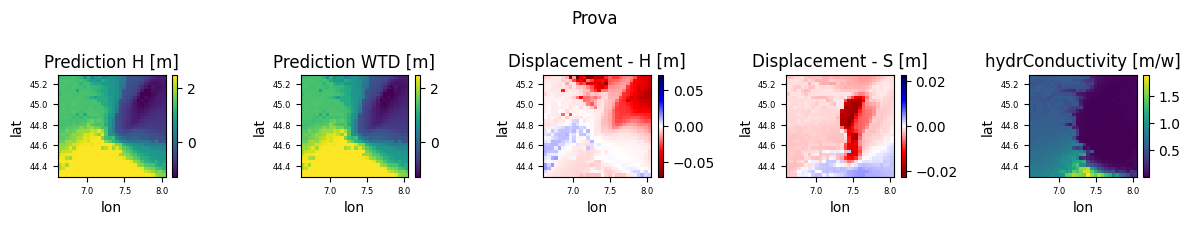

In [39]:
plot_ST_MultiPoint.plot_pred_displacement_maps(predictions_xr[0],
            predictions_xr[0],
            displacement_gw_xr[0],
            displacement_s_xr[0],
            permeability_xr[0],
            title = "Prova",
            print_plot = True)

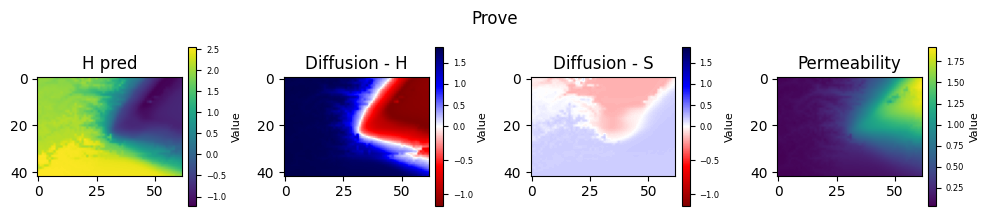

In [66]:
fig, ax = plt.subplots(1,4, figsize = (10,5))

tstep = 3

plt.suptitle("Prove", y = 0.7)

im1 = ax[0].imshow(predictions_grid[tstep])
ax[0].set_title("H pred")
cbar = plt.colorbar(im1, ax = ax[0], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

im2 = ax[1].imshow(Displacement_GW_grid[tstep], cmap = "seismic_r", norm = norm)
ax[1].set_title("Diffusion - H")
cbar = plt.colorbar(im2, ax = ax[1], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

im3 = ax[2].imshow(Displacement_S_grid[tstep], cmap = "seismic_r", norm = norm)
ax[2].set_title("Diffusion - S")
cbar =plt.colorbar(im3, ax = ax[2], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

im4 = ax[3].imshow(Permeability_grid[tstep])
ax[3].set_title("Permeability")
cbar = plt.colorbar(im4, ax = ax[3], fraction=0.05, pad=0.04)
cbar.ax.tick_params(labelsize=6)  # Set tick label size
cbar.set_label('Value', fontsize=8)  # Set label font size (optional)

plt.tight_layout()

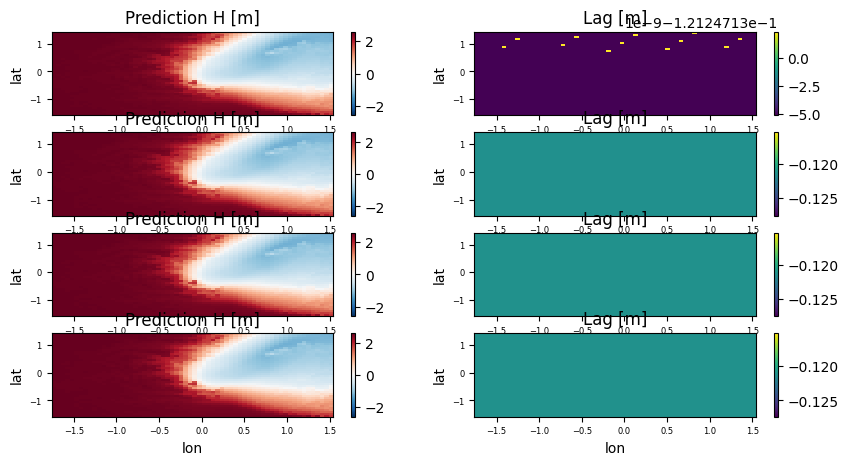

In [132]:
fig, ax = plt.subplots(4,2, figsize = (10,5))

tstep = 3


for tstep in range(4):

    predictions_xr[tstep].plot(ax = ax[tstep,0])
    ax[tstep,0].set_title("Prediction H [m]")
    ax[tstep,0].tick_params(labelsize=6)  # Set tick label size
    
    Lag_GW_xr[tstep].plot(ax = ax[tstep,1])
    ax[tstep,1].set_title("Lag [m]")
    ax[tstep,1].tick_params(labelsize=6)  # Set tick label size

## Time Series

In [15]:
from utils import plot_ST_MultiPoint
importlib.reload(plot_ST_MultiPoint)

<module 'utils.plot_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot_ST_MultiPoint.py'>

In [23]:
ds.weather_coords.shape

(9, 12, 3)

In [ ]:
["2016-02-07","2018-06-03","2019-02-03","2022-10-02"]
["2019-01-06","2020-06-07"]

In [17]:
date = np.datetime64("2022-10-02")
n_pred = 1
true, predictions = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, date, n_pred)

100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


In [14]:
_, predictions_iter = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, date, n_pred, iter_pred = True)

100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


In [26]:
true_ds = plot_ST_MultiPoint.build_ds_from_pred(true.detach().cpu(), ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
true_ds = (true_ds * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]
pred_ds = plot_ST_MultiPoint.build_ds_from_pred(predictions.detach().cpu(), ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
pred_ds = (pred_ds * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]
# pred_iter_ds = plot_ST_MultiPoint.build_ds_from_pred(predictions_iter, ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
# pred_iter_ds = (pred_iter_ds * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]

In [27]:
true_ds[sensor].isna().all()

np.False_

In [29]:
ds[0][0][0].shape

torch.Size([4, 28])

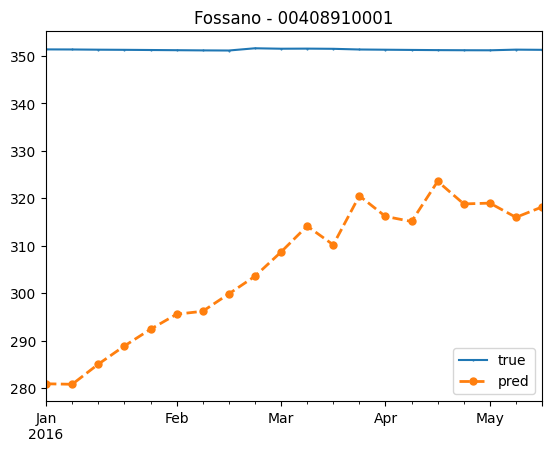

In [28]:
sensor_idx = 20
sensor = ds.sensor_id_list[sensor_idx]
munic = ds.wtd_geodf.loc[ds.wtd_geodf["sensor_id"] == sensor,"munic"].values[0]

fig, ax = plt.subplots(1,1)
min = np.inf
max = 0
true_ds[sensor].plot(label = "true", ax = ax, marker = "o", markersize = 0.5)
pred_ds[sensor].plot(label = "pred", ax = ax, marker = "o",  linestyle = "--" , markersize = 5, linewidth = 2)
#pred_iter_ds[sensor].plot(label = "pred_iter")
plt.title(f"{munic} - {sensor}")

# if true_ds[sensor].isna().all():
#     if min 
#     min_ = pred_ds[sensor].min(skipna=True)*(1-0.025)
#     max = pred_ds[sensor].max(skipna=True)*(1+0.025)
# else:
#     min = true_ds[sensor].min(skipna=True)*(1-0.025)
#     max = true_ds[sensor].max(skipna=True)*(1+0.025)

# plt.ylim(min,
#          max)
plt.legend()
plt.show()

## Displacements

In [32]:
date = np.datetime64("2021-07-04")
n_pred = 52
model.eval()
iter_pred = True
true, predictions, Displacement_GW, Displacement_S, Permeability, Lag_GW = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, date, n_pred,
                                                                        get_displacement_terms = True,
                                                                        iter_pred=iter_pred)

100%|██████████| 52/52 [00:12<00:00,  4.01it/s]


In [33]:
mean_xr = ds.weather_xr.sel(time = slice(date,date+np.timedelta64(n_pred-1, "W")))
mean_prec = mean_xr["tp"].mean(dim = ("lat","lon")).values

In [34]:
true_ds = plot_ST_MultiPoint.build_ds_from_pred(true, ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
true_ds = (true_ds * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]

pred_ds = plot_ST_MultiPoint.build_ds_from_pred(predictions.detach().cpu(), ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
pred_ds = (pred_ds * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]

dis_gw_ds = plot_ST_MultiPoint.build_ds_from_pred(Displacement_GW.detach().cpu(), ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
dis_gw_ds *= ds.norm_factors["target_stds"]

dis_s_ds = plot_ST_MultiPoint.build_ds_from_pred(Displacement_S.detach().cpu(), ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
dis_s_ds *= ds.norm_factors["target_stds"]

permeability_ds = plot_ST_MultiPoint.build_ds_from_pred(Permeability.detach().cpu(), ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
lag_gw_ds = plot_ST_MultiPoint.build_ds_from_pred(Lag_GW.detach().cpu(), ds, start_date=date, n_pred=n_pred, sensor_names=ds.sensor_id_list)
lag_gw_ds = (lag_gw_ds * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]


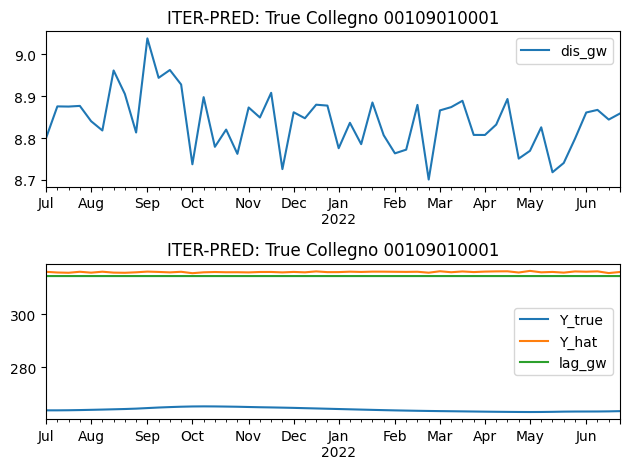

In [37]:
sensor_idx = 6
sensor = ds.sensor_id_list[sensor_idx]

fig, ax = plt.subplots(2,1)


dis_gw_ds[sensor].plot(label = "dis_gw", ax = ax[0])
#dis_s_ds[sensor].plot(label = "dis_s", ax = ax[0])

ax[0].set_title(f"ITER-PRED: {iter_pred} {ds.wtd_geodf.loc[ds.wtd_geodf['sensor_id'] == sensor,'munic'].values[0]} {sensor}")
ax[0].legend()

true_ds[sensor].plot(label = "Y_true", ax = ax[1])
pred_ds[sensor].plot(label = "Y_hat", ax = ax[1])

lag_gw_ds[sensor].plot(label = "lag_gw", ax = ax[1])

ax[1].set_title(f"ITER-PRED: {iter_pred} {ds.wtd_geodf.loc[ds.wtd_geodf['sensor_id'] == sensor,'munic'].values[0]} {sensor}")
ax[1].legend()
plt.tight_layout()

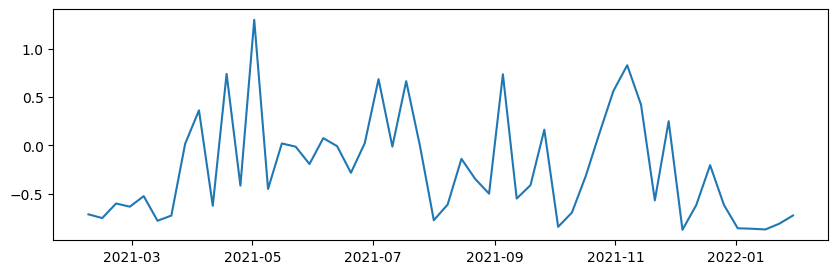

In [24]:
fig, ax  = plt.subplots(figsize = (10,3))
plt.plot(lag_gw_ds.index,
         mean_prec, label = "prec")

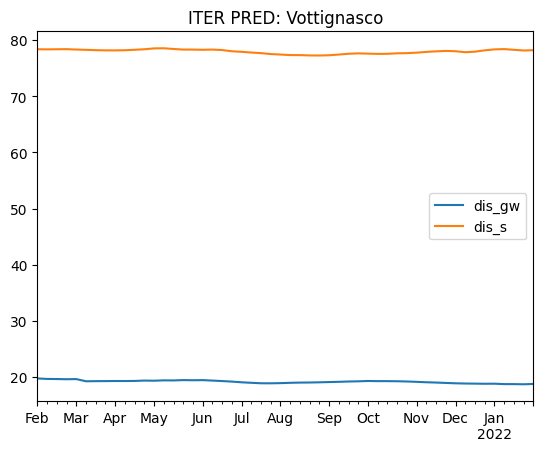

In [44]:
sensor_idx = 27
sensor = ds.sensor_id_list[sensor_idx]

# true_ds[sensor].plot(label = "Y_true")
# pred_ds[sensor].plot(label = "Y_hat")
dis_gw_ds[sensor].plot(label = "dis_gw")
dis_s_ds[sensor].plot(label = "dis_s")
#lag_gw_ds[sensor].plot(label = "lag_gw")
plt.title(f"ITER PRED: {ds.wtd_geodf.loc[ds.wtd_geodf['sensor_id'] == sensor,'munic'].values[0]}")
plt.legend()
plt.show()

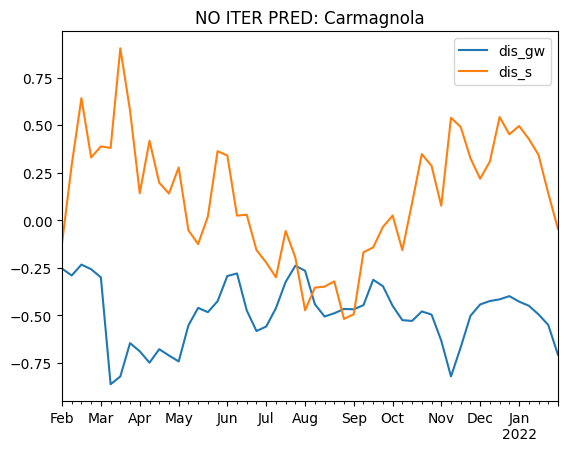

In [59]:
sensor_idx = 3
sensor = ds.sensor_id_list[sensor_idx]

# true_ds[sensor].plot(label = "Y_true")
# pred_ds[sensor].plot(label = "Y_hat")
dis_gw_ds[sensor].plot(label = "dis_gw")
dis_s_ds[sensor].plot(label = "dis_s")
#lag_gw_ds[sensor].plot(label = "lag_gw")
plt.title(f"NO ITER PRED: {ds.wtd_geodf.loc[ds.wtd_geodf['sensor_id'] == sensor,'munic'].values[0]}")
plt.legend()
plt.show()

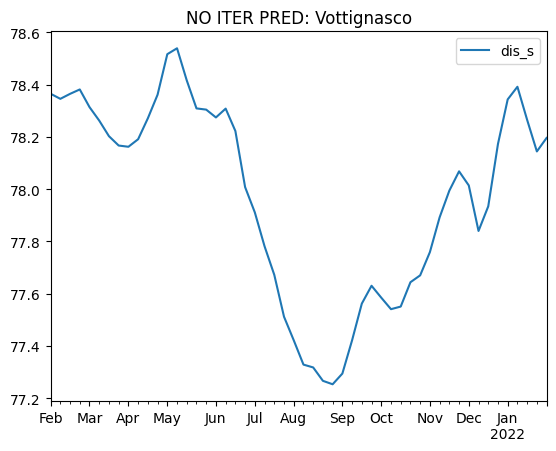

In [37]:
sensor_idx = 27
sensor = ds.sensor_id_list[sensor_idx]

# true_ds[sensor].plot(label = "Y_true")
# pred_ds[sensor].plot(label = "Y_hat")
#dis_gw_ds[sensor].plot(label = "dis_gw")
dis_s_ds[sensor].plot(label = "dis_s")
#lag_gw_ds[sensor].plot(label = "lag_gw")
plt.title(f"NO ITER PRED: {ds.wtd_geodf.loc[ds.wtd_geodf['sensor_id'] == sensor,'munic'].values[0]}")
plt.legend()
plt.show()

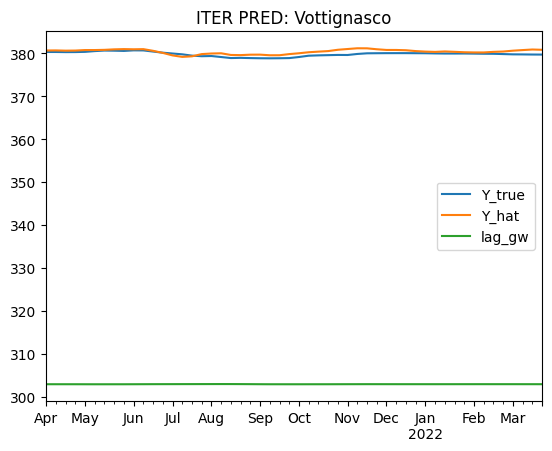

In [66]:
sensor_idx = 27
sensor = ds.sensor_id_list[sensor_idx]

true_ds[sensor].plot(label = "Y_true")
pred_ds[sensor].plot(label = "Y_hat")
# dis_gw_ds[sensor].plot(label = "dis_gw")
# dis_s_ds[sensor].plot(label = "dis_s")
lag_gw_ds[sensor].plot(label = "lag_gw")
plt.title(f"ITER PRED: {ds.wtd_geodf.loc[ds.wtd_geodf['sensor_id'] == sensor,'munic'].values[0]}")
plt.legend()
plt.show()

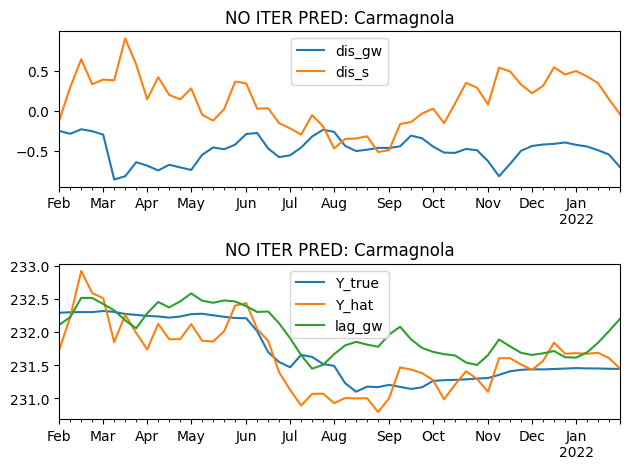

In [73]:
ds[0][2].shape

torch.Size([28, 5])

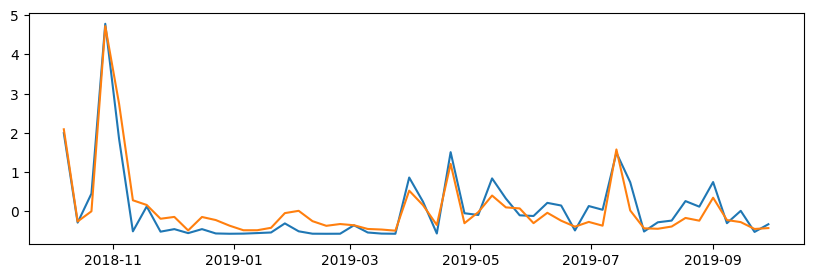

In [48]:
fig, ax  = plt.subplots(figsize = (10,3))
plt.plot(lag_gw_ds.index,
         mean_prec, label = "prain")
plt.plot(lag_gw_ds.index,
         mean_snowm, label = "snowm")

In [31]:
subset_df = ds.lagged_df.loc[pd.IndexSlice[np.datetime64("2021-06-27"),:],:]
X = ds.get_lagged_features(subset_df)
Y, _ = ds.get_target_values(subset_df)

In [45]:
X[1][:,27]

tensor([[-0.7510,  0.4636, -0.8527,  0.0857, -0.9963],
        [-0.7510,  0.4636, -0.8527,  0.2046, -0.9789],
        [-0.7510,  0.4636, -0.8527,  0.3204, -0.9473],
        [-0.7510,  0.4636, -0.8527,  0.4317, -0.9020]])

In [30]:
X[0][:,27]

tensor([1.1127, 1.1163, 1.1199, 1.1200])

In [34]:
X[0][0,27]

tensor(1.1163)

In [27]:
Y[27]

tensor(1.1101)

In [32]:
Y[27]

tensor(1.1127)

In [68]:
np.sin((2 * np.pi * pd.DatetimeIndex(["2021-06-27"]).day_of_year.values)/366) 

array([0.0857305])

In [67]:
np.cos((2 * np.pi * pd.DatetimeIndex(["2021-06-27"]).day_of_year.values)/366) 

array([-0.99631836])

In [48]:
X[2][:,27]

tensor([False, False, False, False])

In [44]:
(X[0][:,27] * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]

tensor([380.1510, 380.4134, 380.6781, 380.6900])

In [ ]:
plt.plot(true_ds[sensor].index,
         mean_prec, label = "prain")
plt.plot(true_ds[sensor].index,
         mean_snowm, label = "snowm")

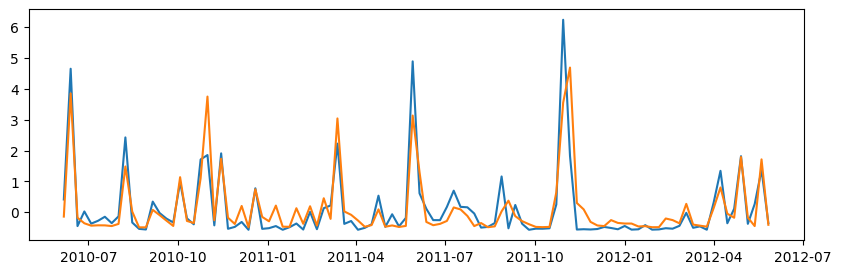

In [37]:
daterange = pd.date_range(date,date+np.timedelta64(104, "W"), freq = "W")
fig, ax  = plt.subplots(figsize = (10,3))
plt.plot(daterange,
         mean_prec, label = "prain")
plt.plot(daterange,
         mean_snowm, label = "snowm")

In [ ]:
plt.plot(true_ds[sensor].index,
         mean_prec, label = "prain")
plt.plot(true_ds[sensor].index,
         mean_snowm, label = "snowm")

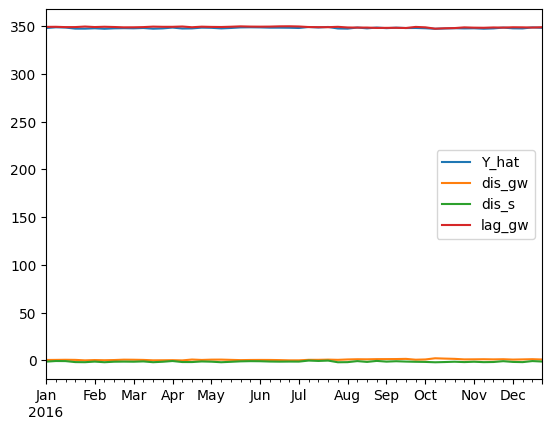

In [54]:
sensor_idx = 0
sensor = ds.sensor_id_list[sensor_idx]

pred_ds[sensor].plot(label = "Y_hat")
dis_gw_ds[sensor].plot(label = "dis_gw")
dis_s_ds[sensor].plot(label = "dis_s")
lag_gw_ds[sensor].plot(label = "lag_gw")
plt.legend()
plt.show()

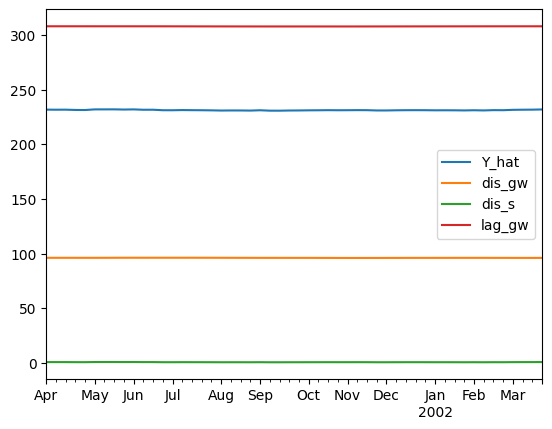

In [ ]:
sensor_idx = 3
sensor = ds.sensor_id_list[sensor_idx]

pred_ds[sensor].plot(label = "Y_hat")
dis_gw_ds[sensor].plot(label = "dis_gw")
dis_s_ds[sensor].plot(label = "dis_s")
lag_gw_ds[sensor].plot(label = "lag_gw")
plt.legend()
plt.show()

[]

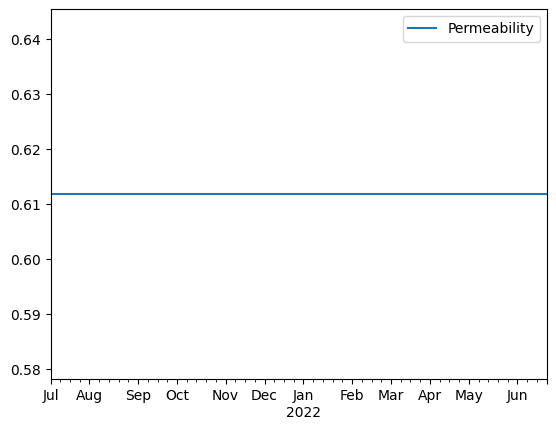

In [30]:
permeability_ds[sensor].plot(label = "Permeability")
plt.legend()
plt.plot()

# Maps and GIFs

In [41]:
main_path = "/leonardo_work/IscrC_DL4EO/trials"
data_path = f"{main_path}/data"

piemonte_shp = gpd.read_file(f"{data_path}/shapefile/piemonte_admin_boundaries.shp", engine='fiona')
piemonte_shp = piemonte_shp.to_crs('epsg:4326')

# remove the small enclaved Cuneo area inside Torino province
piemonte_shp = piemonte_shp[:-1]

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
piemonte_shp.boundary.plot(ax = ax, color = "black", label = "Piedmont's bounds")

In [ ]:
predictions_xr
displacement_gw_xr
displacement_s_xr
permeability_xr
Lag_GW_xr

In [43]:
importlib.reload(plot_ST_MultiPoint)

<module 'utils.plot_ST_MultiPoint' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/utils/plot_ST_MultiPoint.py'>

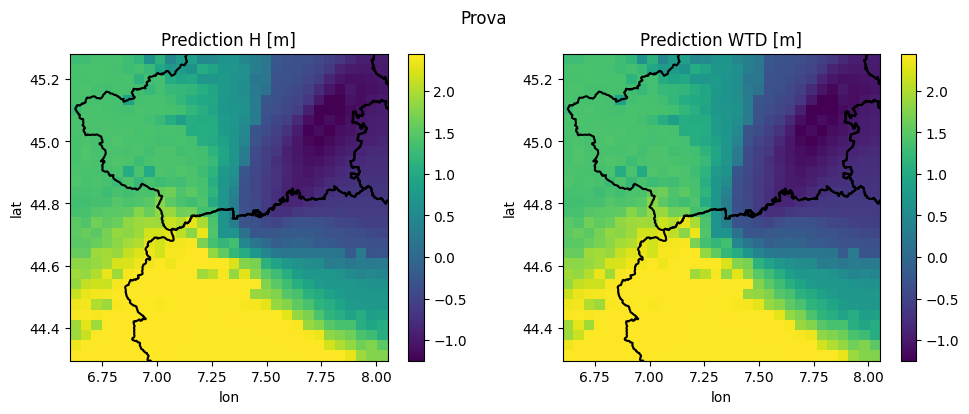

In [48]:
plot_ST_MultiPoint.plot_map(predictions_xr.sel(time = "2021-07-04"),
        predictions_xr[0],
                 title = "Prova",
                 shapefile = piemonte_shp,
                 vmin = None,
                 vmax = None,
                 save_dir = None, 
                 print_plot = True)

## plot all H (or WTD)

In [52]:
def plot_map_all_models(predictions_xr_list,
            title,
            shapefile,
            model_names,
            var_name_title = "H [m]",
            save_dir = None, 
            print_plot = False):
    
    ## Plot the maps
    
    fig, ax = plt.subplots(1,len(predictions_xr_list), figsize = (10,4))
    fig.suptitle(title)

    for model_i in range(len(predictions_xr_list)):
        predictions_xr_list[model_i].plot(ax = ax[model_i])
    
        shapefile.boundary.plot(ax = ax[model_i],
                                color = "black",
                                label = "Piedmont's bounds")
    
        ax[model_i].set_title(f"{model_names[model_i]} {var_name_title}")

    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight',
                    dpi = 400, transparent = True)
    
    if print_plot is True:
        plt.tight_layout()
        
    else:
        return fig 

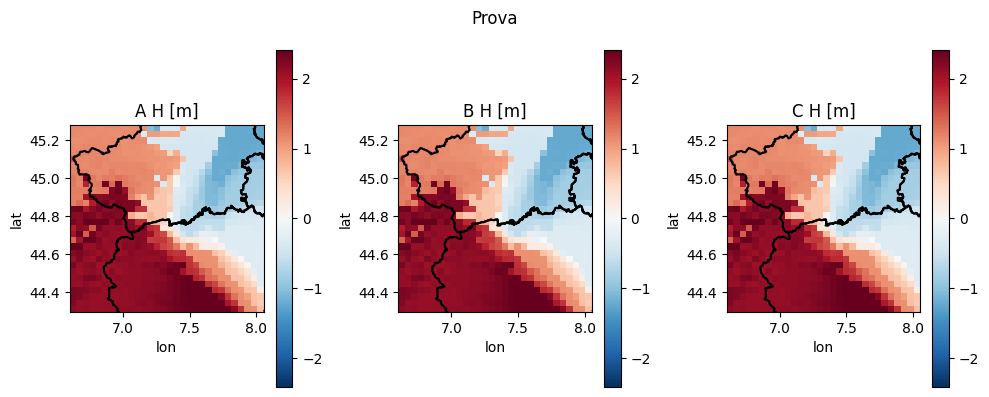

In [23]:
plot_ST_MultiPoint.plot_map_all_models([predictions_xr.sel(time = "2021-07-04"),
                                        predictions_xr.sel(time = "2021-07-04"),
                                        predictions_xr.sel(time = "2021-07-04")],
            title = "Prova",
            shapefile = ds.piemonte_shp,
            model_names = ["A","B","C"],
            var_name_title = "H [m]",
            save_dir = None, 
            print_plot = True)

## plot displacements

In [101]:
def plot_displacement_all_models(displacement_pred_list,
            title,
            shapefile,
            model_names,
            save_dir = None, 
            print_plot = False):
    
    ## Plot the maps
    
    fig, ax = plt.subplots(len(displacement_pred_list),
                           3, figsize = (10,5))
    fig.suptitle(title)

    for model_i in range(len(displacement_pred_list)):
        
        ### Displacement H
        im0 = displacement_pred_list[model_i][0].plot(ax = ax[model_i,0],
                cmap = "seismic_r",# norm = norm
                cbar_kwargs={"shrink": 0.9})
        shapefile.boundary.plot(ax = ax[model_i,0],
                                color = "black",
                                label = "Piedmont's bounds")
        ax[model_i,0].set_title(r"{} $\Delta_{{GW}}$ [m]".format(model_names[model_i]))
        #cbar = plt.colorbar(im0, ax = ax[model_i,0], fraction=0.05, pad=0.04)
        ax[model_i,0].tick_params(labelsize=6)  # Set tick label size
        
        ### Displacement S
        im1 = displacement_pred_list[model_i][1].plot(ax = ax[model_i,1],
            cmap = "seismic_r",# norm = norm
            cbar_kwargs={"shrink": 0.9})
        shapefile.boundary.plot(ax = ax[model_i,1],
                                color = "black",
                                label = "Piedmont's bounds")
        ax[model_i,1].set_title(r"{} $\Delta_S$ [m]".format(model_names[model_i]))
        #cbar = plt.colorbar(im1, ax = ax[model_i,1], fraction=0.05, pad=0.04)
        ax[model_i,1].tick_params(labelsize=6)  # Set tick label size
        
        ### Conductivity
        im2 = displacement_pred_list[model_i][2].plot(ax = ax[model_i,2],
                                                      cbar_kwargs={"shrink": 0.9})
        shapefile.boundary.plot(ax = ax[model_i,2],
                                    color = "black",
                                    label = "Piedmont's bounds")
        ax[model_i,2].set_title(r"{} K [m/w]".format(model_names[model_i]))
        #cbar = plt.colorbar(im2, ax = ax[model_i,2], fraction=0.05, pad=0.04)
        ax[model_i,2].tick_params(labelsize=6)  # Set tick label size


    plt.tight_layout(pad=1.0, h_pad=0.25, w_pad=0.5)
    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight',
                    dpi = 400, transparent = True)
    
    if print_plot is True:
        plt.plot()
        
    else:
        return fig 

In [ ]:
displacement_gw_xr
displacement_s_xr
permeability_xr

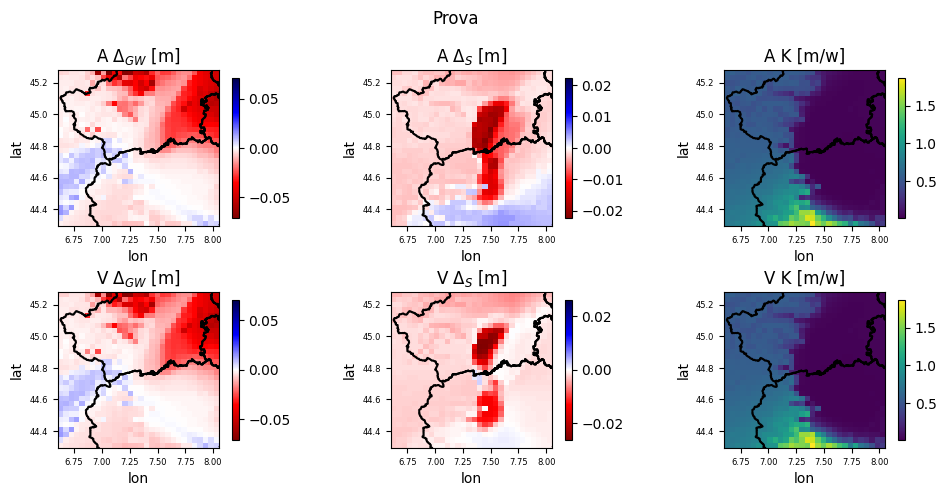

In [102]:
plot_displacement_all_models([[displacement_gw_xr[0],displacement_s_xr[0],permeability_xr[0]],
                              [displacement_gw_xr[1],displacement_s_xr[1],permeability_xr[1]]],
            title = "Prova",
            shapefile = piemonte_shp,
            model_names = ["A","V"],
            save_dir = None, 
            print_plot = True)

# GIF

In [109]:
date = np.datetime64("2021-07-04")
n_pred = 3

In [ ]:
def generate_gif_from_xr(start_date, n_pred,
                       xr,
                       title,
                       freq,
                       save_dir = None,
                       print_plot = False):
    
    def update_h_wtd_maps(i):
        
        sample_date_i = np.datetime64(start_date) + np.timedelta64(i, freq)
        
        fig.suptitle(f"t0: {start_date} - lead time: {i} {sample_date_i} ",
                     x=0.45, ha="center", y=0.1)
        
        ax.set_title(title)
        
        image.set_array(xr[i,:,:])
        
        return image

    fig, ax = plt.subplots(1,1, figsize = (7,5) )
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.2, top = 0.9, left=0.1)          # leave space for suptitle
    
    fig.suptitle(f"t0: {start_date} - lead time: {0}",
                 x=0.45, ha="center", y=0.1)
    image = xr[0,:,:].plot(ax = ax, animated=True,
                                                vmin = xr.min().values,
                                                vmax = xr.max().values)
    ax.set_title(title)


    
        
        ## Plot the maps
        
        
    ani = animation.FuncAnimation(fig, update_h_wtd_maps, repeat=True, frames=n_pred, interval=1)

    writer = animation.PillowWriter(fps=1,
                                    metadata=dict(artist='Me'),
                                    bitrate=1800,
                                    )
    
    if save_dir:
        ani.save(f'{save_dir}.gif', writer=writer,
                 dpi=400)
        
    if print_plot is True:
        plt.show()

In [24]:
"fgb-fir".replace("-","_")

'fgb_fir'

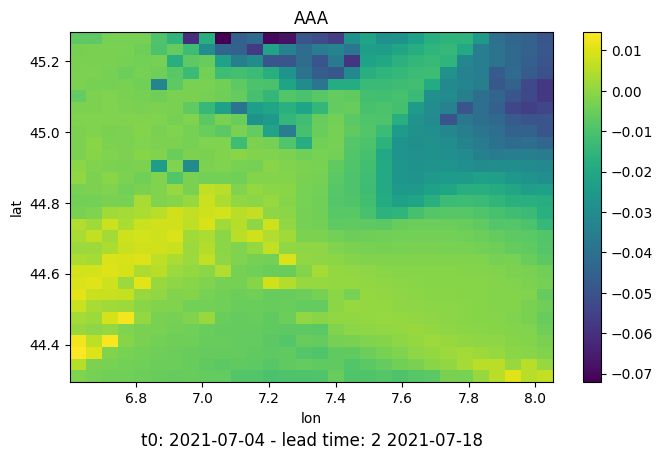

In [210]:
generate_gif_from_xr(date, n_pred,
                    displacement_gw_xr,
                    title = "AAA",
                    freq = "W",
                       save_dir = "/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/notebooks/gif_prova",
                       print_plot = False)

# Old

In [ ]:
pred_ds = plot_ST_MultiPoint.build_ds_from_pred(predictions, ds, start_date=np.datetime64("2001-04-01"), n_pred=n_pred, sensor_names=ds.sensor_id_list)
pred_iter_ds = plot_ST_MultiPoint.build_ds_from_pred(predictions_iter, ds, start_date=np.datetime64("2001-04-01"), n_pred=n_pred, sensor_names=ds.sensor_id_list)
true_ds = plot_ST_MultiPoint.build_ds_from_pred(true, ds, start_date=np.datetime64("2001-04-01"), n_pred=n_pred, sensor_names=ds.sensor_id_list)

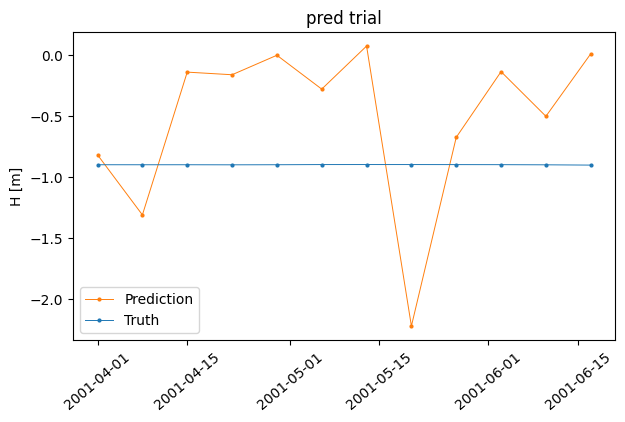

In [34]:
sensor = 3
sensor_id = ds.sensor_id_list[sensor]
plot_ST_MultiPoint.plot_time_series(pred_iter_ds[sensor_id],
                                    true_ds[sensor_id],
                                    title = "pred trial",
                                    print_plot=True)

In [35]:
lat_points = 42
lon_points = 62
Z_grid = plot_ST_MultiPoint.grid_generation(ds, lat_points,lon_points)

In [36]:
true, predictions = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, np.datetime64("2001-04-01"), 12,
                                                Z_grid = Z_grid)

100%|██████████| 12/12 [00:18<00:00,  1.50s/it]


In [37]:
predictions.shape

torch.Size([12, 2604])

In [38]:
predictions_grid = predictions.reshape(12,lat_points,lon_points)

In [40]:
true, predictions_iter = plot_ST_MultiPoint.compute_predictions_ST_MultiPoint(ds, model, device, np.datetime64("2001-04-01"), 12, iter_pred = True,
                                                     Z_grid = Z_grid)

100%|██████████| 12/12 [00:20<00:00,  1.74s/it]


In [41]:
predictions_iter_grid = predictions_iter.reshape(12,lat_points,lon_points)

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

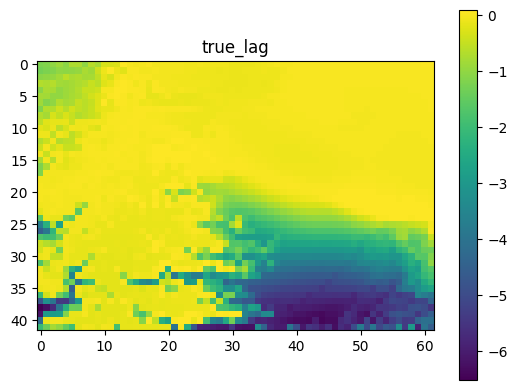

In [42]:
plt.imshow(predictions_grid[5,:,:])
plt.colorbar()
plt.title("true_lag")
plt.plot

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>

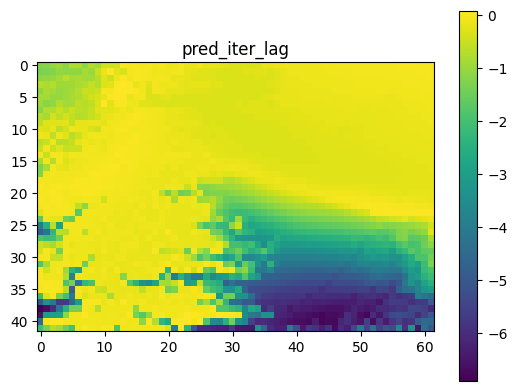

In [43]:
plt.imshow(predictions_iter_grid[5,:,:])
plt.colorbar()
plt.title("pred_iter_lag")
plt.plot

In [81]:
predictions_iter_grid.shape

torch.Size([12, 42, 62])

In [82]:
Z_grid.shape

(2604, 3)

In [84]:
Z_grid_reshape = Z_grid.reshape(lat_points,lon_points,3)
Z_grid_reshape.shape

(42, 62, 3)

In [ ]:
Z_grid_reshape[:,0,0] # lat
Z_grid_reshape[0,:,1] # lon

array([ 1.40201997,  1.32991321,  1.25780645,  1.18569968,  1.11359292,
        1.04148616,  0.96937939,  0.89727263,  0.82516587,  0.7530591 ,
        0.68095234,  0.60884558,  0.53673881,  0.46463205,  0.39252529,
        0.32041852,  0.24831176,  0.176205  ,  0.10409824,  0.03199147,
       -0.04011529, -0.11222205, -0.18432882, -0.25643558, -0.32854234,
       -0.40064911, -0.47275587, -0.54486263, -0.6169694 , -0.68907616,
       -0.76118292, -0.83328969, -0.90539645, -0.97750321, -1.04960997,
       -1.12171674, -1.1938235 , -1.26593026, -1.33803703, -1.41014379,
       -1.48225055, -1.55435732])

In [92]:
#np.datetime64("2001-04-01"), 12
start_date_idx = ds.dates.get_loc(np.datetime64("2001-04-01"))
dates = [ds.dates[start_date_idx+i] for i in range(12)]
dates

[Timestamp('2001-04-01 00:00:00'),
 Timestamp('2001-04-08 00:00:00'),
 Timestamp('2001-04-15 00:00:00'),
 Timestamp('2001-04-22 00:00:00'),
 Timestamp('2001-04-29 00:00:00'),
 Timestamp('2001-05-06 00:00:00'),
 Timestamp('2001-05-13 00:00:00'),
 Timestamp('2001-05-20 00:00:00'),
 Timestamp('2001-05-27 00:00:00'),
 Timestamp('2001-06-03 00:00:00'),
 Timestamp('2001-06-10 00:00:00'),
 Timestamp('2001-06-17 00:00:00')]

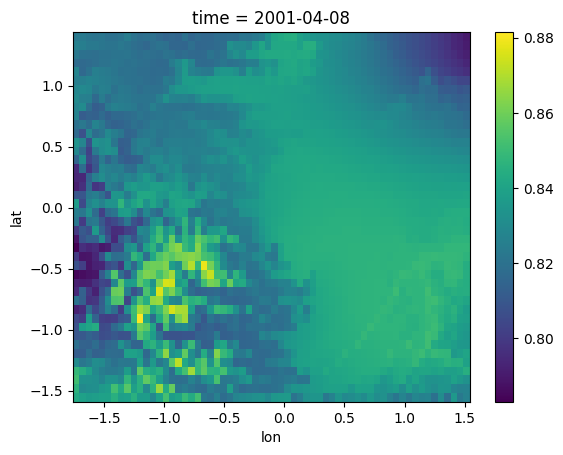

In [96]:
predictions_iter_xr = xarray.DataArray(data = predictions_iter_grid,
                                coords = dict(
                                            lat=("lat", Z_grid_reshape[:,0,0]),
                                            lon=("lon", Z_grid_reshape[0,:,1]),
                                            time=dates),
                                dims = ["time","lat", "lon"]
                                )
predictions_iter_xr[1].plot()

In [100]:
ds.norm_factors["dtm_mean"].values

array(1139.4907, dtype=float32)

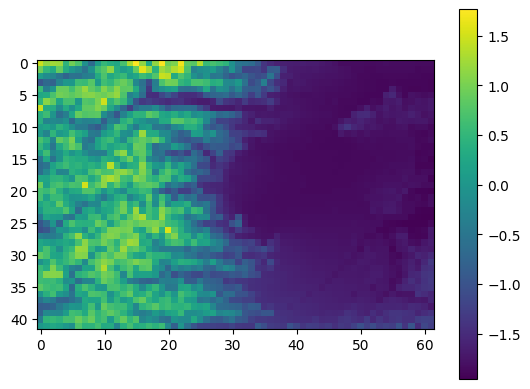

In [103]:
plt.imshow(Z_grid_reshape[:,:,2] - predictions_iter_xr[1])
plt.colorbar()

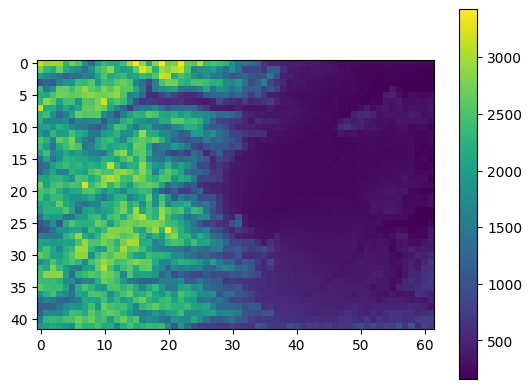

In [102]:
plt.imshow((Z_grid_reshape[:,:,2]*ds.norm_factors["dtm_std"].values) + ds.norm_factors["dtm_mean"].values)
plt.colorbar()

In [108]:
def plot_map(predictions_xr, true_xr,
                 title,
                 x_label = "WTD",
                 vmin = None,
                 vmax = None,
                 save_dir = None, 
                 print_plot = False):
    
    ## Plot the maps
    
    fig, ax = plt.subplots(1,2, figsize = (10,4))
    fig.suptitle(title)
    
    vmin = vmin if vmin is not None else true_xr.min().values
    vmax = vmax if vmax is not None else true_xr.max().values

    predictions_xr.plot(ax = ax[0],
                vmin = vmin,
                vmax = vmax)
    ax[0].set_title(f"Prediction {x_label} [m]")

    true_xr.plot(ax = ax[1],
                vmin = vmin,
                vmax = vmax)
    ax[1].set_title(f"True {x_label} [m]")

    if save_dir:
        plt.savefig(f"{save_dir}.png", bbox_inches = 'tight') #dpi = 400, transparent = True
    
    if print_plot is True:
        plt.tight_layout()
        
    else:
        return fig 

In [109]:
predictions_iter_xr.min()

<xarray.DataArray ()> Size: 4B
array(-1.1965674, dtype=float32)

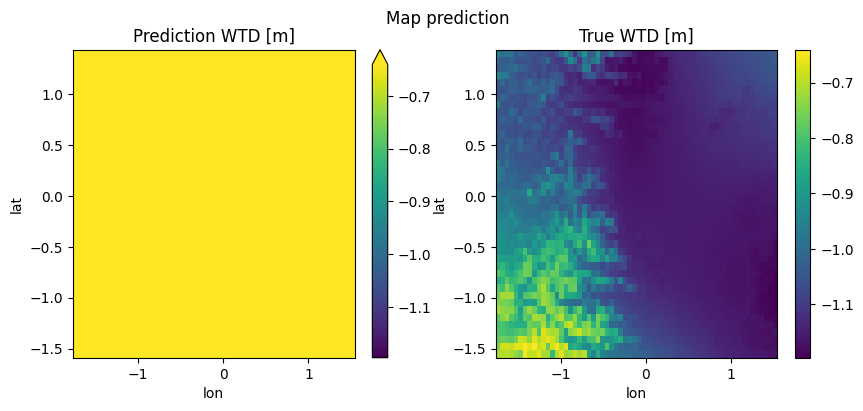

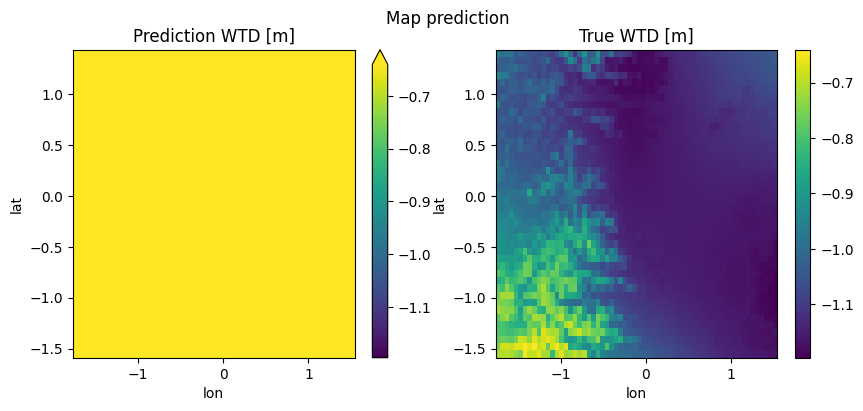

In [ ]:
plot_map(predictions_iter_xr[0],
         predictions_iter_xr[10],
                 title = f"Map prediction",
                 x_label = "WTD",
                 vmin = None,
                 vmax = None,
                 save_dir = None, 
                 print_plot = False)

## Load trained model

In [83]:
model_name_path = "model_SparseData_Transformer_20250717_171819" #" model_ViViT_STMoE_20250626_123108"
model_path = f"/leonardo_scratch/fast/IscrC_DL4EO/results/results_SparseData/models/{model_name_path}.pt"
model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))
model.eval()

RuntimeError: Error(s) in loading state_dict for ST_MultiPoint_DisNet_K:
	Missing key(s) in state_dict: "Value_Embedding_GW.ST_layers.0.weight", "Value_Embedding_GW.ST_layers.0.bias", "Value_Embedding_GW.ST_layers.2.weight", "Value_Embedding_GW.ST_layers.2.bias", "Value_Embedding_GW.ST_layers.4.weight", "Value_Embedding_GW.ST_layers.4.bias", "Value_Embedding_Weather.ST_layers.0.weight", "Value_Embedding_Weather.ST_layers.0.bias", "Value_Embedding_Weather.ST_layers.2.weight", "Value_Embedding_Weather.ST_layers.2.bias", "Value_Embedding_Weather.ST_layers.4.weight", "Value_Embedding_Weather.ST_layers.4.bias", "ST_coords_Embedding.ST_layers.0.weight", "ST_coords_Embedding.ST_layers.0.bias", "ST_coords_Embedding.ST_layers.2.weight", "ST_coords_Embedding.ST_layers.2.bias", "ST_coords_Embedding.ST_layers.4.weight", "ST_coords_Embedding.ST_layers.4.bias", "HydrConductivity.ST_layers.0.weight", "HydrConductivity.ST_layers.0.bias", "HydrConductivity.ST_layers.2.weight", "HydrConductivity.ST_layers.2.bias", "HydrConductivity.ST_layers.4.weight", "HydrConductivity.ST_layers.4.bias", "HydrConductivity_Linear.0.weight", "GW_lags_Module.multihead_att.in_proj_weight", "GW_lags_Module.multihead_att.in_proj_bias", "GW_lags_Module.multihead_att.out_proj.weight", "GW_lags_Module.multihead_att.out_proj.bias", "GW_lags_Module.norm_linear.0.weight", "GW_lags_Module.norm_linear.0.bias", "GW_lags_Module.norm_linear.2.weight", "GW_lags_Module.norm_linear.2.bias", "GW_lags_Module.norm_linear.4.weight", "GW_lags_Module.norm_linear.4.bias", "Weather_lags_Module.multihead_att.in_proj_weight", "Weather_lags_Module.multihead_att.in_proj_bias", "Weather_lags_Module.multihead_att.out_proj.weight", "Weather_lags_Module.multihead_att.out_proj.bias", "Weather_lags_Module.norm_linear.0.weight", "Weather_lags_Module.norm_linear.0.bias", "Weather_lags_Module.norm_linear.2.weight", "Weather_lags_Module.norm_linear.2.bias", "Weather_lags_Module.norm_linear.4.weight", "Weather_lags_Module.norm_linear.4.bias", "Linear_S.0.weight", "Linear_S.0.bias", "Linear_S.1.weight", "Linear_S.1.bias", "Displacement_Module_GW_0.norm_layer_1.weight", "Displacement_Module_GW_0.norm_layer_1.bias", "Displacement_Module_GW_0.mha.in_proj_weight", "Displacement_Module_GW_0.mha.in_proj_bias", "Displacement_Module_GW_0.mha.out_proj.weight", "Displacement_Module_GW_0.mha.out_proj.bias", "Displacement_Module_GW_0.norm_layer_2.weight", "Displacement_Module_GW_0.norm_layer_2.bias", "Displacement_Module_GW_0.mlp.0.weight", "Displacement_Module_GW_0.mlp.0.bias", "Displacement_Module_GW_0.mlp.2.weight", "Displacement_Module_GW_0.mlp.2.bias", "Displacement_Module_S_0.norm_layer_1.weight", "Displacement_Module_S_0.norm_layer_1.bias", "Displacement_Module_S_0.mha.in_proj_weight", "Displacement_Module_S_0.mha.in_proj_bias", "Displacement_Module_S_0.mha.out_proj.weight", "Displacement_Module_S_0.mha.out_proj.bias", "Displacement_Module_S_0.norm_layer_2.weight", "Displacement_Module_S_0.norm_layer_2.bias", "Displacement_Module_S_0.mlp.0.weight", "Displacement_Module_S_0.mlp.0.bias", "Displacement_Module_S_0.mlp.2.weight", "Displacement_Module_S_0.mlp.2.bias", "Displacement_Module_GW_1.norm_layer_1.weight", "Displacement_Module_GW_1.norm_layer_1.bias", "Displacement_Module_GW_1.mha.in_proj_weight", "Displacement_Module_GW_1.mha.in_proj_bias", "Displacement_Module_GW_1.mha.out_proj.weight", "Displacement_Module_GW_1.mha.out_proj.bias", "Displacement_Module_GW_1.norm_layer_2.weight", "Displacement_Module_GW_1.norm_layer_2.bias", "Displacement_Module_GW_1.mlp.0.weight", "Displacement_Module_GW_1.mlp.0.bias", "Displacement_Module_GW_1.mlp.2.weight", "Displacement_Module_GW_1.mlp.2.bias", "Displacement_Module_S_1.norm_layer_1.weight", "Displacement_Module_S_1.norm_layer_1.bias", "Displacement_Module_S_1.mha.in_proj_weight", "Displacement_Module_S_1.mha.in_proj_bias", "Displacement_Module_S_1.mha.out_proj.weight", "Displacement_Module_S_1.mha.out_proj.bias", "Displacement_Module_S_1.norm_layer_2.weight", "Displacement_Module_S_1.norm_layer_2.bias", "Displacement_Module_S_1.mlp.0.weight", "Displacement_Module_S_1.mlp.0.bias", "Displacement_Module_S_1.mlp.2.weight", "Displacement_Module_S_1.mlp.2.bias", "Linear_Lag.0.weight", "Linear_Lag.0.bias", "Linear_2_GW.0.weight", "Linear_2_GW.0.bias", "GW_diffusion.0.weight", "GW_diffusion.0.bias", "GW_diffusion.1.weight", "GW_diffusion.1.bias", "GW_diffusion.3.weight", "GW_diffusion.3.bias", "GW_diffusion.4.weight", "GW_diffusion.4.bias", "GW_diffusion.6.weight", "GW_diffusion.6.bias", "GW_diffusion.7.weight", "GW_diffusion.7.bias", "GW_diffusion.9.weight", "GW_diffusion.9.bias", "Linear_2_S.0.weight", "Linear_2_S.0.bias". 
	Unexpected key(s) in state_dict: "SparseAutoreg_Module.topo_embeddings.0.weight", "SparseAutoreg_Module.topo_embeddings.0.bias", "SparseAutoreg_Module.value_embeddings.0.weight", "SparseAutoreg_Module.value_embeddings.0.bias", "SparseAutoreg_Module.cb_multihead_att_1.in_proj_weight", "SparseAutoreg_Module.cb_multihead_att_1.in_proj_bias", "SparseAutoreg_Module.cb_multihead_att_1.out_proj.weight", "SparseAutoreg_Module.cb_multihead_att_1.out_proj.bias", "SparseAutoreg_Module.norm_linear.0.weight", "SparseAutoreg_Module.norm_linear.0.bias", "SparseAutoreg_Module.norm_linear.2.weight", "SparseAutoreg_Module.norm_linear.2.bias", "ST_Conditioning_Module.ST_layers.0.weight", "ST_Conditioning_Module.ST_layers.0.bias", "ST_Conditioning_Module.ST_layers.2.weight", "ST_Conditioning_Module.ST_layers.2.bias", "ST_Conditioning_Module.ST_layers.4.weight", "ST_Conditioning_Module.ST_layers.4.bias", "Weather_Module.topo_embeddings.0.weight", "Weather_Module.topo_embeddings.0.bias", "Weather_Module.value_embeddings.0.weight", "Weather_Module.value_embeddings.0.bias", "Weather_Module.cb_multihead_att_1.in_proj_weight", "Weather_Module.cb_multihead_att_1.in_proj_bias", "Weather_Module.cb_multihead_att_1.out_proj.weight", "Weather_Module.cb_multihead_att_1.out_proj.bias", "Weather_Module.norm_linear.0.weight", "Weather_Module.norm_linear.0.bias", "Weather_Module.norm_linear.2.weight", "Weather_Module.norm_linear.2.bias", "Fusion_Embedding.0.weight", "Fusion_Embedding.0.bias", "MHA_Block_0.mha.in_proj_weight", "MHA_Block_0.mha.in_proj_bias", "MHA_Block_0.mha.out_proj.weight", "MHA_Block_0.mha.out_proj.bias", "MHA_Block_0.mlp.0.weight", "MHA_Block_0.mlp.0.bias", "MHA_Block_0.mlp.2.weight", "MHA_Block_0.mlp.2.bias", "linear.0.weight", "linear.0.bias", "output.0.weight", "output.0.bias", "output.2.weight", "output.2.bias". 

In [60]:
date = "2020-01-05"
twindow = 5
lat_points = 30
lon_points = 45
z_grid = plot.grid_generation(ds, lat_points,lon_points)
Y_test, Y_hat_test = plot.compute_predictions(start_date = np.datetime64(date),
                                        twindow = twindow,
                                        model = model,
                                        device = device,
                                        dataset = ds,
                                        Z_grid = z_grid,
                                        eval = True)

Computing Causal-Mask...


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


In [61]:
coords = z_grid.reshape(lat_points,lon_points,3)
Y_hat_test_grid = Y_hat_test.reshape(twindow,lat_points,lon_points)
Y_hat_test_grid = (Y_hat_test_grid * ds.norm_factors["target_stds"]) + ds.norm_factors["target_means"]

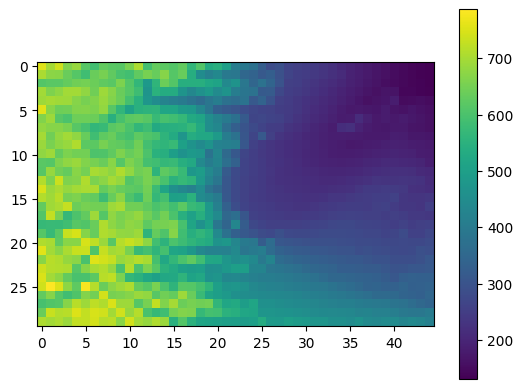

In [66]:
plt.imshow(Y_hat_test_grid[3,:,:])
plt.colorbar()

# Loss

In [36]:
prova = torch.arange(0,10).unsqueeze(0).repeat((10,1))[None,None,:,:].to(torch.float32)
print(prova, end = "\n\n")
print(Fdiff_conv(prova, mode = "first_lat"), end = "\n\n")
print(Fdiff_conv(prova, mode = "first_lon"), end = "\n\n")

tensor([[[[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.],
          [0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]]]])

tensor([[[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        

In [37]:
Fdiff_conv(prova, mode = "first_lon").shape

torch.Size([1, 1, 10, 10])

In [147]:
from loss import losses_SparseData
importlib.reload(losses_SparseData)

<module 'loss.losses_SparseData' from '/leonardo_scratch/fast/IscrC_DL4EO/github/water-pinns/src/loss/losses_SparseData.py'>

In [137]:
batch_s = 5
x_batch = torch.stack([ds[i][0] for i in range(batch_s)], dim = 0)
z_batch = torch.stack([ds[i][1] for i in range(batch_s)], dim = 0)
w0_batch = torch.stack([ds[0][2][0] for i in range(batch_s)], dim = 0)
w1_batch = torch.stack([ds[0][2][1] for i in range(batch_s)], dim = 0)
w_batch = [w0_batch, w1_batch]
true_batch = torch.stack([ds[i][-3] for i in range(batch_s)], dim = 0)
xmask_batch = torch.stack([ds[i][-2] for i in range(batch_s)], dim = 0)
ymask_batch = torch.stack([ds[i][-1] for i in range(batch_s)], dim = 0)

In [138]:
model.train()
out_batch = model(x_batch,
                  z_batch,
                  w_batch,
                  xmask_batch,
                       teacher_forcing = True)

In [139]:
norm_factor = [torch.tensor(ds.norm_factors["target_means"]).to(out_batch.device).to(torch.float32),
            torch.tensor(ds.norm_factors["target_stds"]).to(out_batch.device).to(torch.float32)
            ]

In [87]:
out_batch.shape

torch.Size([5, 26, 28])

In [92]:
true_batch.shape

torch.Size([5, 26, 28])

In [155]:
losses_SparseData.loss_masked_h2(out_batch, true_batch, ymask_batch,
            norm_factor)

tensor([[[ 90.5781,  92.5830, 174.8781,  ...,  29.5957,  22.5359,  22.7983],
         [-64.9565, 140.8301, 129.6301,  ..., 140.9766, -96.3849, -89.1852],
         [365.5546, 294.0675, 331.7056,  ..., 175.5725, -87.6100, -76.2506],
         ...,
         [132.6866, 142.8001, 102.6010,  ..., 179.1476, 217.8306, 159.3986],
         [144.0751, 129.7386, 119.3159,  ..., 178.4463, 214.8107, 164.2427],
         [ 94.8056, 176.8314, 163.9642,  ..., 208.4325, 158.4632, 236.5394]],

        [[606.7235, 489.5417, 328.0421,  ..., 177.7885, 223.4379, 154.7892],
         [406.4716, 359.2103, 241.4683,  ..., 133.3777,  28.8863,  31.6063],
         [681.2541, 538.9100, 276.3175,  ...,   3.5021, 166.3419, 149.5751],
         ...,
         [233.0011, 172.5778, 160.3578,  ..., 268.0643, 193.9412, 220.2015],
         [261.3091, 267.8188, 282.5597,  ..., 237.8039, 175.3546, 191.8213],
         [260.9424, 256.3831, 264.4753,  ..., 270.7410, 223.3766, 209.6097]],

        [[405.7957, 393.7622, 336.9928,  ...

tensor(453407.5312, grad_fn=<DivBackward0>)

In [150]:
h2_denorm = losses_SparseData.point_h2((out_batch* norm_factor[1]) + norm_factor[0],
         (true_batch* norm_factor[1]) + norm_factor[0],
         ymask_batch,
         torch.sum(ymask_batch, dim = 1))

In [151]:
h2_norm = losses_SparseData.point_h2(out_batch,
         true_batch,
         ymask_batch,
         torch.sum(ymask_batch, dim = 1))

In [156]:
Y_tstep_avail_mask = (torch.sum(ymask_batch, dim = 1) > 1)
Y_tstep_avail_mask.shape

torch.Size([5, 28])

In [157]:
torch.sum(h2_denorm[Y_tstep_avail_mask])/torch.sum(Y_tstep_avail_mask)

tensor(453407.5312, grad_fn=<DivBackward0>)

In [158]:
torch.sum(h2_norm[Y_tstep_avail_mask])/torch.sum(Y_tstep_avail_mask)

tensor(1748253.1250, grad_fn=<DivBackward0>)